# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

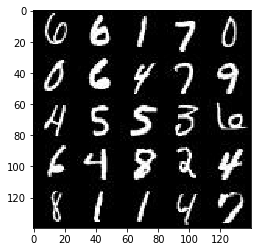

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

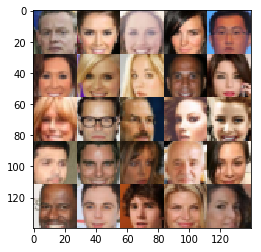

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_img = tf.placeholder(tf.float32,  (None, image_width, image_height, image_channels), name = "real_input_img")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name = 'z_input')
    learning_rate = tf.placeholder(tf.float32, (None)) 

    
    return real_input_img, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False, alpha = 0.1,):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        layer1 = tf.layers.conv2d(images, 64, 3, strides = 2, padding = 'SAME')
        relu_unit1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu_unit1, 128, 3, strides = 2, padding = 'SAME')
        batch_norm1 = tf.layers.batch_normalization(layer2, training = True)
        relu_unit2 = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        layer3 = tf.layers.conv2d(relu_unit2, 256, 3, strides = 2, padding = 'SAME')
        batch_norm2 = tf.layers.batch_normalization(layer3, training = True)
        relu_unit3 = tf.maximum(alpha * batch_norm2, batch_norm2)
       
        
        
        ######## drop = tf.add(Dropout(0.2)) ??????
        
        
        
        #layer4 = tf.layers.conv2d(relu_unit3, 512, 5, strides = 1, padding = 'SAME')
        #batch_norm3 = tf.layers.batch_normalization(layer4, training = True)
        #relu_unit4 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        flatten = tf.reshape(relu_unit3, (-1, 4*4*256))
        logit = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logit)
    
    
    return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """


    with tf.variable_scope('generator', reuse=not is_train):
  
        x1 = tf.layers.dense(z, 2*2*32)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 32))
     
        x1 = tf.maximum(alpha * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        #x5 = tf.layers.conv2d_transpose(x4, 32, 5, strides=2, padding='SAME')
        #x5 = tf.layers.batch_normalization(x5, training=is_train)
        #x5 = tf.maximum(alpha * x5, x5)
        
        
        logit = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
       
        
        
        output = tf.tanh(logit)
        
        
        return output
    
    
    
    
    
#def generator(z, out_channel_dim, is_train=True, alpha = 0.2):

    # TODO: Implement Function

   # with tf.variable_scope('generator', reuse=not is_train):

        #x1_full = tf.layers.dense(z, 2*2*512)
     
        #x1_reshape = tf.reshape(x1_full, (-1, 2, 2, 512))
        #x1_max = tf.maximum(alpha * x1_full, x1_reshape)
      
        
        #x2_conv = tf.layers.conv2d_transpose(x1_full, 256, 4, strides=3, padding='valid')
        #x2_batch_norm = tf.layers.batch_normalization(x2_conv, training=is_train)
        #x2_max = tf.maximum(alpha * x2_conv, x2_batch_norm)
  
        #x3_conv = tf.layers.conv2d_transpose(x2, 128, 4, strides=3, padding='same')
        #x3_batch_norm = tf.layers.batch_normalization(x3_conv, training=is_train)
        #x3 = tf.maximum(alpha * x3_conv, x3_batch_norm)
        

        #logit = tf.layers.conv2d_transpose(x3_conv, out_channel_dim, 4, strides=3, padding='same')
      
        
     
        #out = tf.tanh(logit)
       


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
import numpy as np
import random

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    discrim_model_real, discrim_logits_real = discriminator(input_real, reuse=False)
    discrim_model_fake, discrim_logits_fake = discriminator(gen_model, reuse=True)
    
    labels = tf.ones_like(discrim_logits_real) * np.random.uniform(0.7, 1.2)
    
    
    discrim_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_real, labels=tf.ones_like(discrim_model_real)))
    discrim_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_fake, labels=tf.zeros_like(discrim_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discrim_logits_fake, labels=tf.ones_like(discrim_model_fake)))

    discrim_loss = discrim_loss_real + discrim_loss_fake

    return discrim_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:



def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_variables =  tf.trainable_variables()
    
    generator_vraiables =  [variable for variable in  trainable_variables if variable.name.startswith('generator')]
    discriminator_vraiables = [variable for variable in  trainable_variables if variable.name.startswith('discriminator')]
    
    discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vraiables)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vraiables)

   # discriminator_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=discriminator_vraibales)
   # generator_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=generator_vraibales)
    
    
    return discriminator_train_opt,  generator_train_opt


    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    
    discrim_loss, gen_loss = model_loss(input_real, input_z, channels)
    
    discrim_opt, gen_opt = model_opt(discrim_loss, gen_loss, learn_rate, beta1)
    
    step = 0
    s_every = 50
    p_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
               
                # TODO: Train Model
                
                step += 1
                batch_images *= 2
                    
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                opt = sess.run(discrim_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                opt = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if step % s_every == 0:
                    n_images = 20
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if step % p_every == 0:
                    train_loss_discrim = discrim_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})

                    print("Epochs {}/{}".format(epoch_i, epoch_count), "Discrim Loss: {:.4f}".format(train_loss_discrim),
                          "Gen Loss: {:.4f}".format(train_loss_gen))
                    
    
    
    ###FAILED ATTEMPT
    
    #samples, image_width, image_height, channels = data_shape
    
    
    
    #real_input, z_input, learning_rate = model_inputs(data_shape[1], data_shape[1], data_shape[1], z_dim)
    
    #discrim_loss, gen_loss = model_loss(real_input, z_input, channels)
    #discrim_opt, gen_opt = model_opt(discrim_loss, gen_loss, learning_rate, beta1)
    
   #steps = 0
    #prnt_every = 10
    #show_every = 50
    
    
   # with tf.Session() as sess:
      #  sess.run(tf.global_variables_initializer())
        #for epoch_i in range(epoch_count):
          #  for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
               # steps += 1
               # batch_images = batch_images * 2
                     
          
              #  z_batches = np.random.uniform(-1, 1, size=(batch_size, z_dim))

        
               # optimizers = sess.run(discrim_opt, feed_dict={real_input: batch_images, z_input: z_batches, learning_rate: learning_rate})
            
                #optimizers = sess.run(gen_opt, feed_dict={real_input: batch_images, z_input: z_batches, learning_rate: learning_rate})

               


                   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epochs 0/5 Discrim Loss: 1.3920 Gen Loss: 0.3647
Epochs 0/5 Discrim Loss: 1.1889 Gen Loss: 0.4851
Epochs 0/5 Discrim Loss: 0.8500 Gen Loss: 3.9979
Epochs 0/5 Discrim Loss: 0.7128 Gen Loss: 0.9683


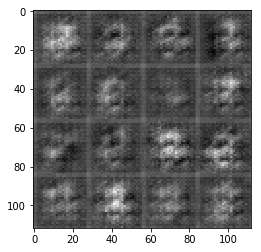

Epochs 0/5 Discrim Loss: 0.7645 Gen Loss: 5.0748
Epochs 0/5 Discrim Loss: 0.7230 Gen Loss: 1.4181
Epochs 0/5 Discrim Loss: 0.4875 Gen Loss: 2.4454
Epochs 0/5 Discrim Loss: 1.3062 Gen Loss: 4.0516
Epochs 0/5 Discrim Loss: 1.1931 Gen Loss: 0.5415


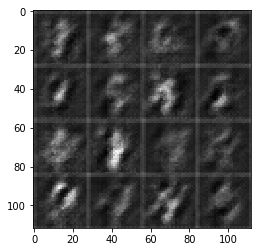

Epochs 0/5 Discrim Loss: 0.5209 Gen Loss: 1.5327
Epochs 0/5 Discrim Loss: 0.7677 Gen Loss: 3.6002
Epochs 0/5 Discrim Loss: 0.6994 Gen Loss: 0.9782
Epochs 0/5 Discrim Loss: 0.5686 Gen Loss: 1.3105
Epochs 0/5 Discrim Loss: 0.7447 Gen Loss: 1.3960


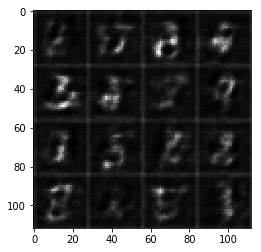

Epochs 0/5 Discrim Loss: 0.7855 Gen Loss: 2.2574
Epochs 0/5 Discrim Loss: 0.6504 Gen Loss: 1.1409
Epochs 0/5 Discrim Loss: 0.8157 Gen Loss: 0.8466
Epochs 0/5 Discrim Loss: 0.5913 Gen Loss: 1.8821
Epochs 0/5 Discrim Loss: 0.9546 Gen Loss: 2.7261


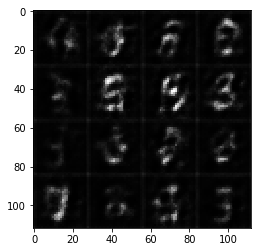

Epochs 0/5 Discrim Loss: 0.6623 Gen Loss: 2.4055
Epochs 0/5 Discrim Loss: 0.9223 Gen Loss: 0.6889
Epochs 0/5 Discrim Loss: 0.7756 Gen Loss: 0.8802
Epochs 0/5 Discrim Loss: 0.4899 Gen Loss: 1.4683
Epochs 0/5 Discrim Loss: 0.4780 Gen Loss: 1.8631


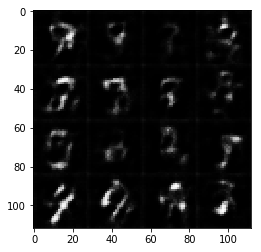

Epochs 0/5 Discrim Loss: 0.6098 Gen Loss: 2.1816
Epochs 0/5 Discrim Loss: 0.4614 Gen Loss: 1.7650
Epochs 0/5 Discrim Loss: 0.4443 Gen Loss: 1.5817
Epochs 0/5 Discrim Loss: 1.0355 Gen Loss: 0.6019
Epochs 0/5 Discrim Loss: 1.0062 Gen Loss: 0.5891


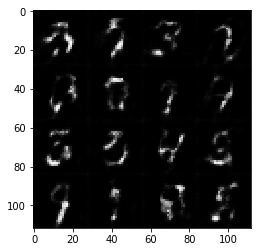

Epochs 0/5 Discrim Loss: 0.5105 Gen Loss: 2.0452
Epochs 0/5 Discrim Loss: 0.4965 Gen Loss: 1.5493
Epochs 0/5 Discrim Loss: 0.4985 Gen Loss: 1.3930
Epochs 0/5 Discrim Loss: 0.6796 Gen Loss: 0.9150
Epochs 0/5 Discrim Loss: 0.7800 Gen Loss: 0.8151


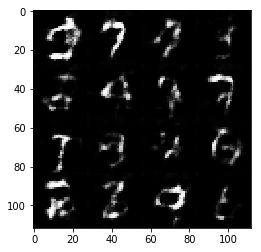

Epochs 0/5 Discrim Loss: 1.8242 Gen Loss: 0.2213
Epochs 0/5 Discrim Loss: 0.6858 Gen Loss: 0.9684
Epochs 0/5 Discrim Loss: 0.4757 Gen Loss: 1.5196
Epochs 0/5 Discrim Loss: 0.5430 Gen Loss: 1.1904
Epochs 0/5 Discrim Loss: 0.4242 Gen Loss: 2.4566


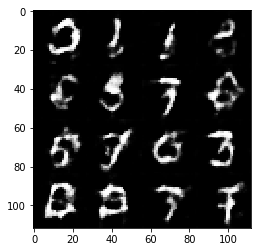

Epochs 0/5 Discrim Loss: 0.5034 Gen Loss: 1.5020
Epochs 0/5 Discrim Loss: 2.1088 Gen Loss: 5.1373
Epochs 0/5 Discrim Loss: 0.4595 Gen Loss: 1.5631
Epochs 0/5 Discrim Loss: 0.5167 Gen Loss: 1.4450
Epochs 0/5 Discrim Loss: 1.4897 Gen Loss: 0.3130


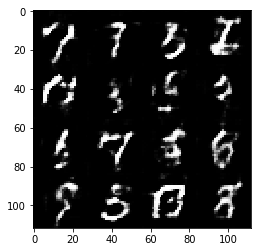

Epochs 0/5 Discrim Loss: 0.9279 Gen Loss: 2.2588
Epochs 0/5 Discrim Loss: 0.6289 Gen Loss: 1.0834
Epochs 0/5 Discrim Loss: 0.4776 Gen Loss: 2.0381
Epochs 0/5 Discrim Loss: 0.5147 Gen Loss: 1.2772
Epochs 0/5 Discrim Loss: 0.4460 Gen Loss: 1.9632


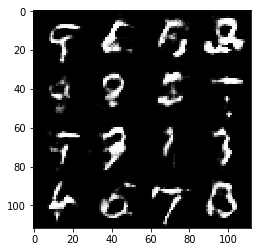

Epochs 0/5 Discrim Loss: 0.6028 Gen Loss: 1.0871
Epochs 0/5 Discrim Loss: 0.5513 Gen Loss: 3.0306
Epochs 0/5 Discrim Loss: 1.8670 Gen Loss: 0.2551
Epochs 0/5 Discrim Loss: 0.6443 Gen Loss: 1.0293
Epochs 0/5 Discrim Loss: 0.5412 Gen Loss: 1.1804


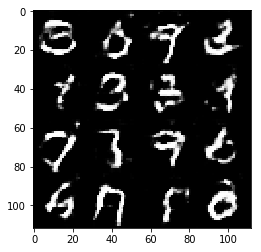

Epochs 0/5 Discrim Loss: 0.3755 Gen Loss: 1.9530
Epochs 0/5 Discrim Loss: 0.4484 Gen Loss: 1.3292
Epochs 0/5 Discrim Loss: 5.6905 Gen Loss: 0.0069
Epochs 0/5 Discrim Loss: 0.8999 Gen Loss: 0.7367
Epochs 0/5 Discrim Loss: 0.5107 Gen Loss: 1.8630


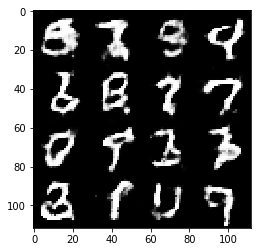

Epochs 0/5 Discrim Loss: 0.4044 Gen Loss: 1.6600
Epochs 0/5 Discrim Loss: 0.4856 Gen Loss: 1.5827
Epochs 0/5 Discrim Loss: 0.4534 Gen Loss: 1.3890
Epochs 0/5 Discrim Loss: 0.5128 Gen Loss: 1.3534
Epochs 0/5 Discrim Loss: 4.5906 Gen Loss: 6.5157


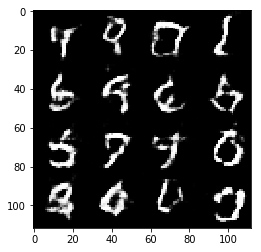

Epochs 0/5 Discrim Loss: 0.6322 Gen Loss: 1.7374
Epochs 0/5 Discrim Loss: 0.3371 Gen Loss: 1.8793
Epochs 0/5 Discrim Loss: 0.3984 Gen Loss: 1.6213
Epochs 0/5 Discrim Loss: 0.4257 Gen Loss: 1.5624
Epochs 0/5 Discrim Loss: 0.8745 Gen Loss: 0.6822


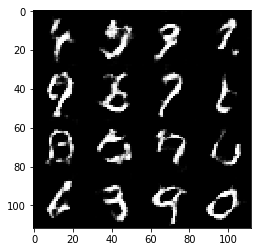

Epochs 0/5 Discrim Loss: 0.4212 Gen Loss: 1.5156
Epochs 0/5 Discrim Loss: 0.4936 Gen Loss: 1.2550
Epochs 0/5 Discrim Loss: 0.3117 Gen Loss: 1.7876
Epochs 0/5 Discrim Loss: 0.4252 Gen Loss: 1.4834
Epochs 0/5 Discrim Loss: 0.3836 Gen Loss: 1.9178


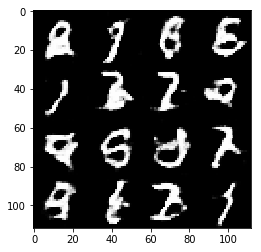

Epochs 0/5 Discrim Loss: 0.3525 Gen Loss: 2.4217
Epochs 0/5 Discrim Loss: 0.3541 Gen Loss: 1.9114
Epochs 0/5 Discrim Loss: 0.3480 Gen Loss: 1.9673
Epochs 0/5 Discrim Loss: 0.4337 Gen Loss: 1.2985
Epochs 0/5 Discrim Loss: 0.3661 Gen Loss: 1.5551


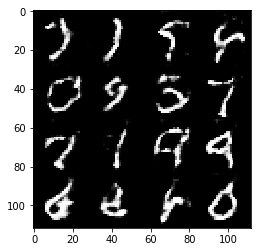

Epochs 0/5 Discrim Loss: 0.3023 Gen Loss: 1.8673
Epochs 0/5 Discrim Loss: 0.2801 Gen Loss: 1.9178
Epochs 0/5 Discrim Loss: 0.3046 Gen Loss: 1.6360
Epochs 0/5 Discrim Loss: 0.2274 Gen Loss: 2.5092
Epochs 0/5 Discrim Loss: 0.5837 Gen Loss: 3.8340


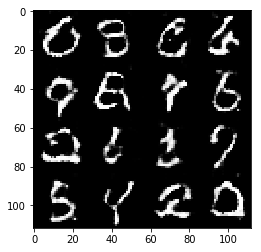

Epochs 0/5 Discrim Loss: 0.3397 Gen Loss: 1.8948
Epochs 0/5 Discrim Loss: 0.3393 Gen Loss: 1.6962
Epochs 0/5 Discrim Loss: 0.2880 Gen Loss: 3.2596
Epochs 0/5 Discrim Loss: 0.4117 Gen Loss: 1.4329
Epochs 0/5 Discrim Loss: 0.2711 Gen Loss: 1.9145


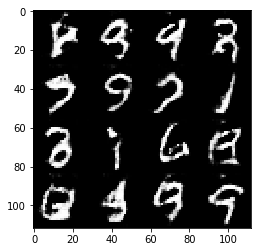

Epochs 0/5 Discrim Loss: 0.7264 Gen Loss: 0.8870
Epochs 0/5 Discrim Loss: 0.9099 Gen Loss: 0.9406
Epochs 0/5 Discrim Loss: 0.3491 Gen Loss: 1.6908
Epochs 0/5 Discrim Loss: 0.7556 Gen Loss: 0.8456
Epochs 1/5 Discrim Loss: 0.5177 Gen Loss: 1.2105


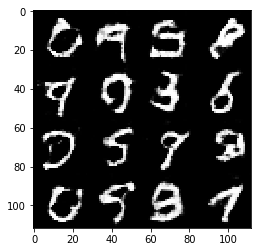

Epochs 1/5 Discrim Loss: 0.4522 Gen Loss: 1.2995
Epochs 1/5 Discrim Loss: 0.4706 Gen Loss: 1.2568
Epochs 1/5 Discrim Loss: 0.3570 Gen Loss: 1.6646
Epochs 1/5 Discrim Loss: 0.3419 Gen Loss: 1.6502
Epochs 1/5 Discrim Loss: 0.2641 Gen Loss: 2.1622


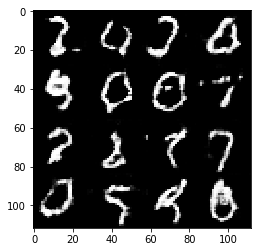

Epochs 1/5 Discrim Loss: 0.2622 Gen Loss: 1.9845
Epochs 1/5 Discrim Loss: 0.1975 Gen Loss: 2.1778
Epochs 1/5 Discrim Loss: 0.2711 Gen Loss: 2.0275
Epochs 1/5 Discrim Loss: 0.3317 Gen Loss: 1.6717
Epochs 1/5 Discrim Loss: 0.8428 Gen Loss: 1.8288


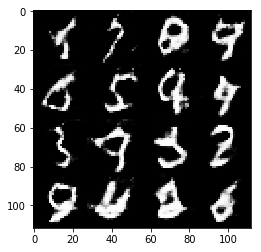

Epochs 1/5 Discrim Loss: 0.9878 Gen Loss: 3.2823
Epochs 1/5 Discrim Loss: 0.5139 Gen Loss: 1.2480
Epochs 1/5 Discrim Loss: 0.5893 Gen Loss: 1.0331
Epochs 1/5 Discrim Loss: 0.2406 Gen Loss: 2.0534
Epochs 1/5 Discrim Loss: 0.2603 Gen Loss: 2.0836


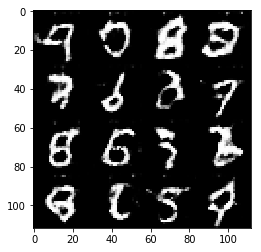

Epochs 1/5 Discrim Loss: 0.3524 Gen Loss: 1.6488
Epochs 1/5 Discrim Loss: 0.1944 Gen Loss: 2.6227
Epochs 1/5 Discrim Loss: 0.2144 Gen Loss: 2.1393
Epochs 1/5 Discrim Loss: 0.3045 Gen Loss: 1.8609
Epochs 1/5 Discrim Loss: 0.2171 Gen Loss: 2.2636


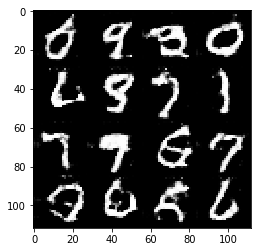

Epochs 1/5 Discrim Loss: 0.2346 Gen Loss: 2.1791
Epochs 1/5 Discrim Loss: 0.2202 Gen Loss: 2.0449
Epochs 1/5 Discrim Loss: 0.3139 Gen Loss: 1.6598
Epochs 1/5 Discrim Loss: 0.3207 Gen Loss: 1.7691
Epochs 1/5 Discrim Loss: 0.3840 Gen Loss: 1.5037


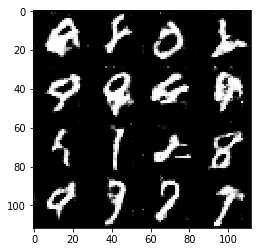

Epochs 1/5 Discrim Loss: 0.2866 Gen Loss: 1.8181
Epochs 1/5 Discrim Loss: 0.2873 Gen Loss: 1.9209
Epochs 1/5 Discrim Loss: 0.2411 Gen Loss: 2.0356
Epochs 1/5 Discrim Loss: 0.1050 Gen Loss: 3.5547
Epochs 1/5 Discrim Loss: 1.1152 Gen Loss: 0.7163


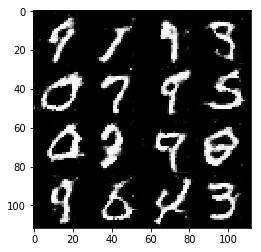

Epochs 1/5 Discrim Loss: 0.6402 Gen Loss: 1.9533
Epochs 1/5 Discrim Loss: 0.9060 Gen Loss: 0.7082
Epochs 1/5 Discrim Loss: 1.4282 Gen Loss: 0.4654
Epochs 1/5 Discrim Loss: 0.2857 Gen Loss: 1.9888
Epochs 1/5 Discrim Loss: 0.2626 Gen Loss: 1.8218


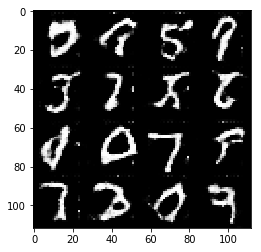

Epochs 1/5 Discrim Loss: 0.2143 Gen Loss: 2.1320
Epochs 1/5 Discrim Loss: 0.4023 Gen Loss: 1.7719
Epochs 1/5 Discrim Loss: 0.8140 Gen Loss: 1.5165
Epochs 1/5 Discrim Loss: 0.6503 Gen Loss: 1.2377
Epochs 1/5 Discrim Loss: 0.5254 Gen Loss: 1.3387


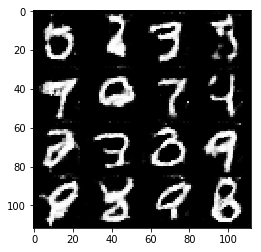

Epochs 1/5 Discrim Loss: 0.6742 Gen Loss: 3.4669
Epochs 1/5 Discrim Loss: 0.3116 Gen Loss: 1.7897
Epochs 1/5 Discrim Loss: 0.2668 Gen Loss: 1.9578
Epochs 1/5 Discrim Loss: 0.3111 Gen Loss: 1.7753
Epochs 1/5 Discrim Loss: 0.1602 Gen Loss: 2.7539


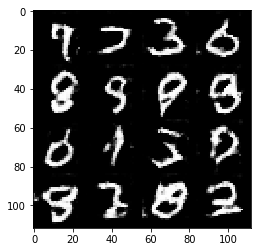

Epochs 1/5 Discrim Loss: 0.3307 Gen Loss: 1.6289
Epochs 1/5 Discrim Loss: 0.2583 Gen Loss: 1.8941
Epochs 1/5 Discrim Loss: 0.2148 Gen Loss: 2.1383
Epochs 1/5 Discrim Loss: 0.1494 Gen Loss: 2.4489
Epochs 1/5 Discrim Loss: 0.1974 Gen Loss: 2.3776


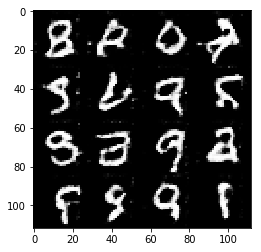

Epochs 1/5 Discrim Loss: 0.1396 Gen Loss: 2.8778
Epochs 1/5 Discrim Loss: 2.1577 Gen Loss: 4.6359
Epochs 1/5 Discrim Loss: 0.3091 Gen Loss: 2.2580
Epochs 1/5 Discrim Loss: 0.2856 Gen Loss: 2.0048
Epochs 1/5 Discrim Loss: 0.2713 Gen Loss: 1.9708


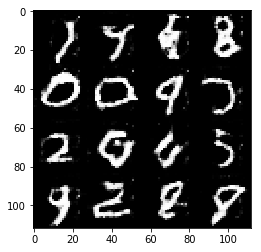

Epochs 1/5 Discrim Loss: 0.1760 Gen Loss: 2.5630
Epochs 1/5 Discrim Loss: 0.2728 Gen Loss: 1.9864
Epochs 1/5 Discrim Loss: 0.2347 Gen Loss: 1.9802
Epochs 1/5 Discrim Loss: 0.3263 Gen Loss: 1.7440
Epochs 1/5 Discrim Loss: 0.1829 Gen Loss: 2.5161


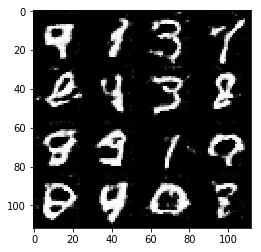

Epochs 1/5 Discrim Loss: 0.2359 Gen Loss: 2.0145
Epochs 1/5 Discrim Loss: 0.2815 Gen Loss: 1.9006
Epochs 1/5 Discrim Loss: 0.2375 Gen Loss: 1.9573
Epochs 1/5 Discrim Loss: 0.3103 Gen Loss: 1.7032
Epochs 1/5 Discrim Loss: 0.0952 Gen Loss: 3.1588


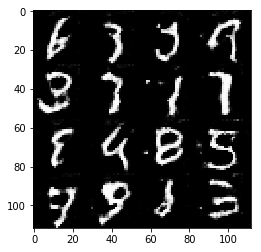

Epochs 1/5 Discrim Loss: 0.2227 Gen Loss: 4.3074
Epochs 1/5 Discrim Loss: 0.3947 Gen Loss: 1.4174
Epochs 1/5 Discrim Loss: 0.3571 Gen Loss: 1.7523
Epochs 1/5 Discrim Loss: 0.2121 Gen Loss: 2.1963
Epochs 1/5 Discrim Loss: 0.2199 Gen Loss: 2.2097


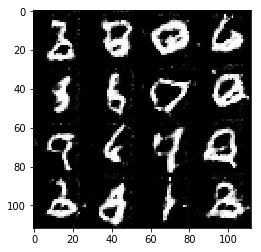

Epochs 1/5 Discrim Loss: 0.3870 Gen Loss: 1.4775
Epochs 1/5 Discrim Loss: 0.1655 Gen Loss: 2.4071
Epochs 1/5 Discrim Loss: 0.1807 Gen Loss: 2.3371
Epochs 1/5 Discrim Loss: 0.4931 Gen Loss: 1.4483
Epochs 1/5 Discrim Loss: 0.1514 Gen Loss: 2.5243


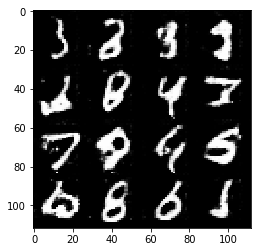

Epochs 1/5 Discrim Loss: 0.1618 Gen Loss: 2.3682
Epochs 1/5 Discrim Loss: 1.9767 Gen Loss: 0.2245
Epochs 1/5 Discrim Loss: 1.3751 Gen Loss: 0.4239
Epochs 1/5 Discrim Loss: 0.6260 Gen Loss: 1.1846
Epochs 1/5 Discrim Loss: 0.2537 Gen Loss: 2.2574


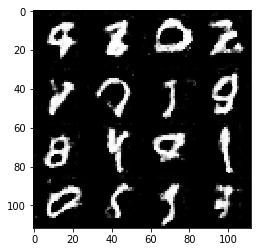

Epochs 1/5 Discrim Loss: 0.3646 Gen Loss: 1.5460
Epochs 1/5 Discrim Loss: 0.2704 Gen Loss: 1.8922
Epochs 1/5 Discrim Loss: 0.1932 Gen Loss: 2.4163
Epochs 1/5 Discrim Loss: 0.2315 Gen Loss: 2.0424
Epochs 1/5 Discrim Loss: 0.2674 Gen Loss: 2.0271


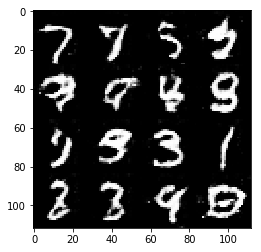

Epochs 1/5 Discrim Loss: 0.2541 Gen Loss: 1.9295
Epochs 1/5 Discrim Loss: 0.1724 Gen Loss: 2.5648
Epochs 1/5 Discrim Loss: 0.1924 Gen Loss: 2.2775
Epochs 1/5 Discrim Loss: 0.1646 Gen Loss: 2.3729
Epochs 1/5 Discrim Loss: 0.2025 Gen Loss: 2.2138


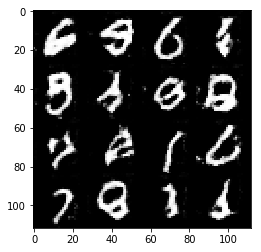

Epochs 1/5 Discrim Loss: 0.2374 Gen Loss: 1.8998
Epochs 1/5 Discrim Loss: 0.2227 Gen Loss: 2.0403
Epochs 1/5 Discrim Loss: 0.2637 Gen Loss: 1.9066
Epochs 2/5 Discrim Loss: 0.4467 Gen Loss: 1.3851
Epochs 2/5 Discrim Loss: 0.1259 Gen Loss: 2.7126


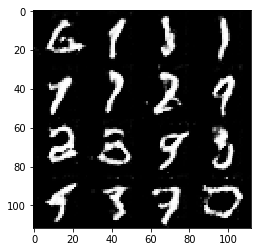

Epochs 2/5 Discrim Loss: 0.1654 Gen Loss: 2.4219
Epochs 2/5 Discrim Loss: 8.3917 Gen Loss: 0.0004
Epochs 2/5 Discrim Loss: 0.8092 Gen Loss: 0.8410
Epochs 2/5 Discrim Loss: 0.8663 Gen Loss: 0.7215
Epochs 2/5 Discrim Loss: 0.9844 Gen Loss: 0.6304


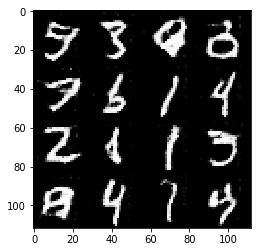

Epochs 2/5 Discrim Loss: 0.4615 Gen Loss: 1.2905
Epochs 2/5 Discrim Loss: 0.2293 Gen Loss: 2.0791
Epochs 2/5 Discrim Loss: 0.2091 Gen Loss: 2.1315
Epochs 2/5 Discrim Loss: 0.2549 Gen Loss: 2.0025
Epochs 2/5 Discrim Loss: 0.1525 Gen Loss: 2.5219


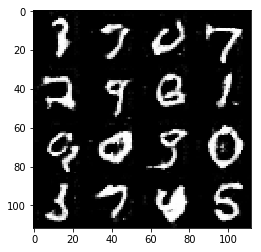

Epochs 2/5 Discrim Loss: 0.4364 Gen Loss: 1.3691
Epochs 2/5 Discrim Loss: 0.1456 Gen Loss: 2.5029
Epochs 2/5 Discrim Loss: 0.1925 Gen Loss: 2.2497
Epochs 2/5 Discrim Loss: 0.1729 Gen Loss: 2.3695
Epochs 2/5 Discrim Loss: 0.4141 Gen Loss: 1.4490


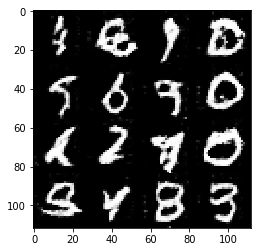

Epochs 2/5 Discrim Loss: 0.2095 Gen Loss: 2.1413
Epochs 2/5 Discrim Loss: 0.2983 Gen Loss: 1.7499
Epochs 2/5 Discrim Loss: 1.0975 Gen Loss: 0.5734
Epochs 2/5 Discrim Loss: 0.1850 Gen Loss: 2.4383
Epochs 2/5 Discrim Loss: 0.1023 Gen Loss: 3.0269


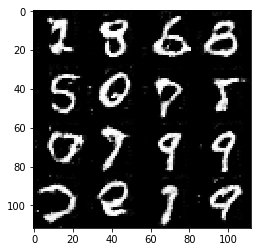

Epochs 2/5 Discrim Loss: 0.0973 Gen Loss: 3.1730
Epochs 2/5 Discrim Loss: 0.1417 Gen Loss: 2.6827
Epochs 2/5 Discrim Loss: 0.2768 Gen Loss: 1.8288
Epochs 2/5 Discrim Loss: 1.9652 Gen Loss: 4.8263
Epochs 2/5 Discrim Loss: 0.3529 Gen Loss: 2.6093


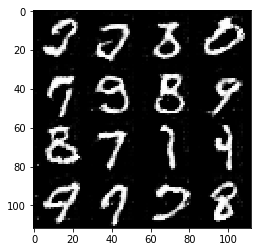

Epochs 2/5 Discrim Loss: 0.6933 Gen Loss: 0.9749
Epochs 2/5 Discrim Loss: 0.3321 Gen Loss: 1.6879
Epochs 2/5 Discrim Loss: 0.1684 Gen Loss: 2.2953
Epochs 2/5 Discrim Loss: 0.2388 Gen Loss: 2.0578
Epochs 2/5 Discrim Loss: 0.2218 Gen Loss: 2.0601


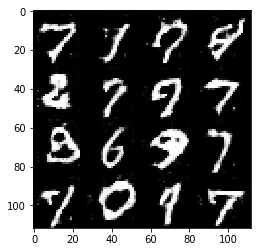

Epochs 2/5 Discrim Loss: 7.1005 Gen Loss: 10.6503
Epochs 2/5 Discrim Loss: 0.3029 Gen Loss: 2.0462
Epochs 2/5 Discrim Loss: 0.4074 Gen Loss: 1.5316
Epochs 2/5 Discrim Loss: 0.2991 Gen Loss: 1.8878
Epochs 2/5 Discrim Loss: 0.3332 Gen Loss: 1.6835


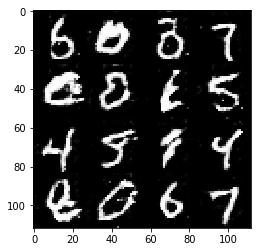

Epochs 2/5 Discrim Loss: 0.2383 Gen Loss: 2.1586
Epochs 2/5 Discrim Loss: 0.2507 Gen Loss: 2.3389
Epochs 2/5 Discrim Loss: 0.2093 Gen Loss: 2.4216
Epochs 2/5 Discrim Loss: 0.2303 Gen Loss: 2.0058
Epochs 2/5 Discrim Loss: 0.1624 Gen Loss: 2.4527


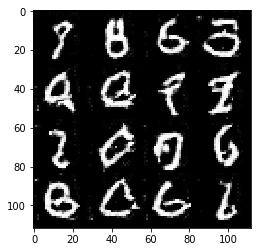

Epochs 2/5 Discrim Loss: 0.2577 Gen Loss: 1.9140
Epochs 2/5 Discrim Loss: 0.3905 Gen Loss: 1.4598
Epochs 2/5 Discrim Loss: 0.3839 Gen Loss: 1.5143
Epochs 2/5 Discrim Loss: 0.3996 Gen Loss: 1.5127
Epochs 2/5 Discrim Loss: 0.2350 Gen Loss: 2.2199


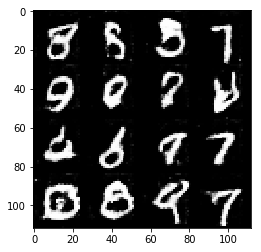

Epochs 2/5 Discrim Loss: 0.1736 Gen Loss: 2.6520
Epochs 2/5 Discrim Loss: 0.6754 Gen Loss: 1.0149
Epochs 2/5 Discrim Loss: 0.1272 Gen Loss: 2.6619
Epochs 2/5 Discrim Loss: 0.2793 Gen Loss: 5.9884
Epochs 2/5 Discrim Loss: 0.4207 Gen Loss: 2.3634


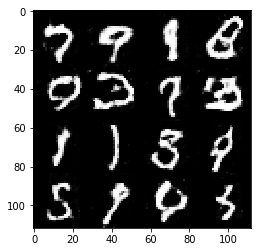

Epochs 2/5 Discrim Loss: 0.6589 Gen Loss: 4.0114
Epochs 2/5 Discrim Loss: 0.2808 Gen Loss: 1.9755
Epochs 2/5 Discrim Loss: 0.1662 Gen Loss: 2.6708
Epochs 2/5 Discrim Loss: 0.2151 Gen Loss: 2.3570
Epochs 2/5 Discrim Loss: 0.3282 Gen Loss: 1.7328


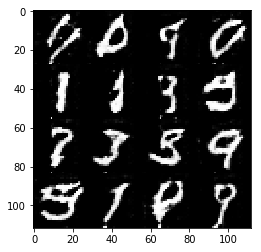

Epochs 2/5 Discrim Loss: 0.2214 Gen Loss: 2.1324
Epochs 2/5 Discrim Loss: 0.2308 Gen Loss: 2.1061
Epochs 2/5 Discrim Loss: 0.2349 Gen Loss: 1.8848
Epochs 2/5 Discrim Loss: 0.2102 Gen Loss: 2.0913
Epochs 2/5 Discrim Loss: 0.3156 Gen Loss: 1.7401


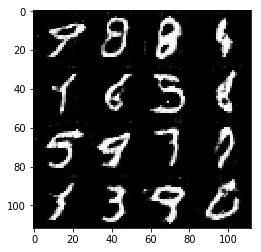

Epochs 2/5 Discrim Loss: 0.1947 Gen Loss: 2.3171
Epochs 2/5 Discrim Loss: 0.1495 Gen Loss: 2.4896
Epochs 2/5 Discrim Loss: 0.1895 Gen Loss: 2.1941
Epochs 2/5 Discrim Loss: 0.1860 Gen Loss: 2.3479
Epochs 2/5 Discrim Loss: 0.1856 Gen Loss: 2.1291


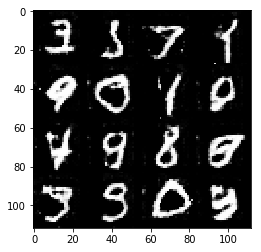

Epochs 2/5 Discrim Loss: 0.3921 Gen Loss: 1.5175
Epochs 2/5 Discrim Loss: 0.2171 Gen Loss: 2.3774
Epochs 2/5 Discrim Loss: 0.1581 Gen Loss: 3.0291
Epochs 2/5 Discrim Loss: 0.2433 Gen Loss: 1.9825
Epochs 2/5 Discrim Loss: 0.4081 Gen Loss: 1.5242


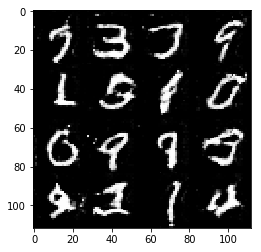

Epochs 2/5 Discrim Loss: 0.2286 Gen Loss: 2.1897
Epochs 2/5 Discrim Loss: 0.1037 Gen Loss: 2.8024
Epochs 2/5 Discrim Loss: 0.2189 Gen Loss: 2.3017
Epochs 2/5 Discrim Loss: 0.1521 Gen Loss: 2.4961
Epochs 2/5 Discrim Loss: 0.5422 Gen Loss: 1.7215


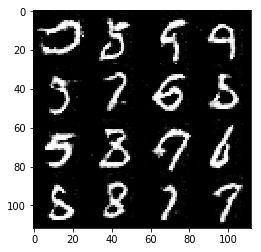

Epochs 2/5 Discrim Loss: 2.5178 Gen Loss: 6.5146
Epochs 2/5 Discrim Loss: 0.6866 Gen Loss: 4.1325
Epochs 2/5 Discrim Loss: 0.4375 Gen Loss: 1.5169
Epochs 2/5 Discrim Loss: 0.2776 Gen Loss: 1.9832
Epochs 2/5 Discrim Loss: 0.3932 Gen Loss: 1.6337


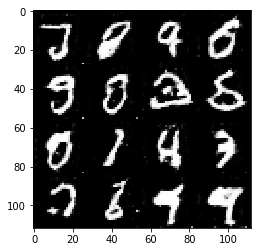

Epochs 2/5 Discrim Loss: 0.2681 Gen Loss: 1.9201
Epochs 2/5 Discrim Loss: 0.1802 Gen Loss: 2.3467
Epochs 2/5 Discrim Loss: 0.4363 Gen Loss: 1.4831
Epochs 2/5 Discrim Loss: 0.2219 Gen Loss: 2.2249
Epochs 2/5 Discrim Loss: 0.1696 Gen Loss: 2.5561


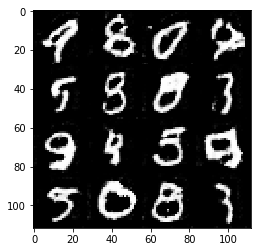

Epochs 2/5 Discrim Loss: 0.2922 Gen Loss: 1.8006
Epochs 2/5 Discrim Loss: 0.1429 Gen Loss: 2.5388
Epochs 2/5 Discrim Loss: 0.1845 Gen Loss: 2.3311
Epochs 2/5 Discrim Loss: 0.1803 Gen Loss: 2.2850
Epochs 2/5 Discrim Loss: 0.2161 Gen Loss: 2.1471


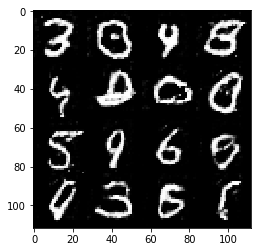

Epochs 2/5 Discrim Loss: 0.1239 Gen Loss: 2.8524
Epochs 2/5 Discrim Loss: 0.1584 Gen Loss: 2.6123
Epochs 3/5 Discrim Loss: 0.3018 Gen Loss: 1.8895
Epochs 3/5 Discrim Loss: 0.2639 Gen Loss: 2.0228
Epochs 3/5 Discrim Loss: 0.1698 Gen Loss: 2.5313


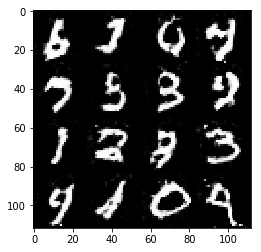

Epochs 3/5 Discrim Loss: 0.0862 Gen Loss: 3.1643
Epochs 3/5 Discrim Loss: 0.2084 Gen Loss: 2.1976
Epochs 3/5 Discrim Loss: 0.1257 Gen Loss: 2.7482
Epochs 3/5 Discrim Loss: 0.2857 Gen Loss: 1.9727
Epochs 3/5 Discrim Loss: 0.1019 Gen Loss: 3.2871


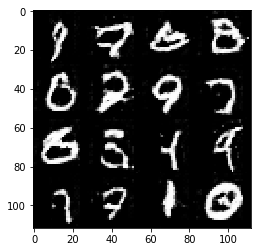

Epochs 3/5 Discrim Loss: 0.1509 Gen Loss: 2.5365
Epochs 3/5 Discrim Loss: 0.1616 Gen Loss: 2.5878
Epochs 3/5 Discrim Loss: 0.1771 Gen Loss: 2.3924
Epochs 3/5 Discrim Loss: 0.2511 Gen Loss: 1.9147
Epochs 3/5 Discrim Loss: 2.6231 Gen Loss: 4.1243


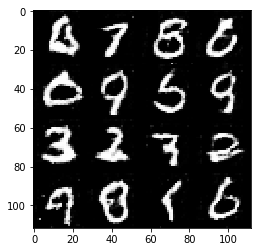

Epochs 3/5 Discrim Loss: 0.7455 Gen Loss: 2.1329
Epochs 3/5 Discrim Loss: 0.6723 Gen Loss: 2.7308
Epochs 3/5 Discrim Loss: 0.4069 Gen Loss: 1.6062
Epochs 3/5 Discrim Loss: 0.4538 Gen Loss: 1.4816
Epochs 3/5 Discrim Loss: 0.6402 Gen Loss: 1.0342


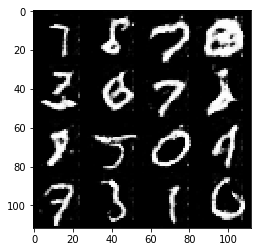

Epochs 3/5 Discrim Loss: 0.3935 Gen Loss: 1.5194
Epochs 3/5 Discrim Loss: 0.2677 Gen Loss: 2.1444
Epochs 3/5 Discrim Loss: 0.5631 Gen Loss: 1.2083
Epochs 3/5 Discrim Loss: 0.3565 Gen Loss: 1.7281
Epochs 3/5 Discrim Loss: 0.8382 Gen Loss: 0.8494


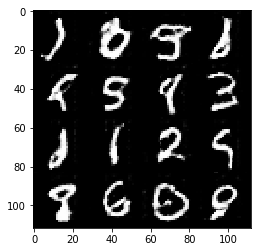

Epochs 3/5 Discrim Loss: 0.1852 Gen Loss: 2.4885
Epochs 3/5 Discrim Loss: 0.2343 Gen Loss: 2.2070
Epochs 3/5 Discrim Loss: 0.3199 Gen Loss: 1.7023
Epochs 3/5 Discrim Loss: 0.3473 Gen Loss: 1.7238
Epochs 3/5 Discrim Loss: 0.3043 Gen Loss: 1.8153


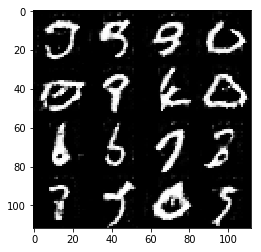

Epochs 3/5 Discrim Loss: 0.2677 Gen Loss: 1.9931
Epochs 3/5 Discrim Loss: 0.2101 Gen Loss: 2.2834
Epochs 3/5 Discrim Loss: 0.1416 Gen Loss: 2.8261
Epochs 3/5 Discrim Loss: 0.3982 Gen Loss: 1.4387
Epochs 3/5 Discrim Loss: 0.2667 Gen Loss: 1.8848


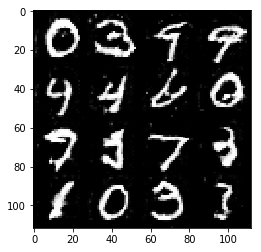

Epochs 3/5 Discrim Loss: 0.1848 Gen Loss: 2.3005
Epochs 3/5 Discrim Loss: 0.1878 Gen Loss: 2.4025
Epochs 3/5 Discrim Loss: 0.2125 Gen Loss: 2.1273
Epochs 3/5 Discrim Loss: 0.2427 Gen Loss: 2.0290
Epochs 3/5 Discrim Loss: 0.1938 Gen Loss: 2.3920


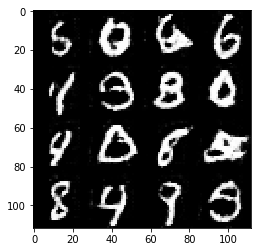

Epochs 3/5 Discrim Loss: 0.1500 Gen Loss: 2.5263
Epochs 3/5 Discrim Loss: 0.3071 Gen Loss: 1.7071
Epochs 3/5 Discrim Loss: 0.6969 Gen Loss: 0.9598
Epochs 3/5 Discrim Loss: 0.2676 Gen Loss: 1.9966
Epochs 3/5 Discrim Loss: 0.3071 Gen Loss: 1.8067


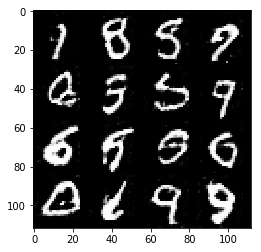

Epochs 3/5 Discrim Loss: 0.1957 Gen Loss: 2.2571
Epochs 3/5 Discrim Loss: 0.2317 Gen Loss: 2.3161
Epochs 3/5 Discrim Loss: 0.1095 Gen Loss: 2.9658
Epochs 3/5 Discrim Loss: 0.1585 Gen Loss: 2.6223
Epochs 3/5 Discrim Loss: 0.2368 Gen Loss: 1.9909


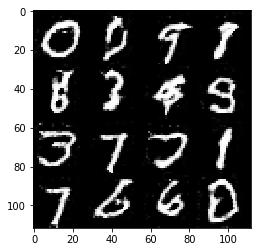

Epochs 3/5 Discrim Loss: 0.1985 Gen Loss: 2.3401
Epochs 3/5 Discrim Loss: 0.1913 Gen Loss: 2.2748
Epochs 3/5 Discrim Loss: 0.1811 Gen Loss: 2.4920
Epochs 3/5 Discrim Loss: 0.0995 Gen Loss: 3.6164
Epochs 3/5 Discrim Loss: 0.7680 Gen Loss: 2.1606


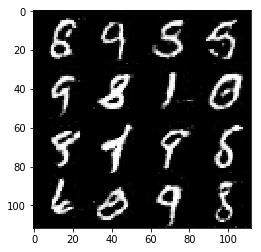

Epochs 3/5 Discrim Loss: 0.5846 Gen Loss: 2.6353
Epochs 3/5 Discrim Loss: 0.8492 Gen Loss: 0.8641
Epochs 3/5 Discrim Loss: 0.4304 Gen Loss: 2.7316
Epochs 3/5 Discrim Loss: 0.9135 Gen Loss: 4.3219
Epochs 3/5 Discrim Loss: 0.8401 Gen Loss: 0.8554


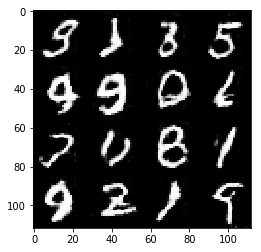

Epochs 3/5 Discrim Loss: 0.5268 Gen Loss: 1.2876
Epochs 3/5 Discrim Loss: 0.4805 Gen Loss: 1.4971
Epochs 3/5 Discrim Loss: 0.2779 Gen Loss: 1.8444
Epochs 3/5 Discrim Loss: 0.2031 Gen Loss: 2.7521
Epochs 3/5 Discrim Loss: 0.1918 Gen Loss: 2.5992


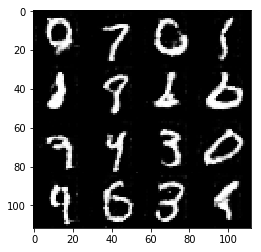

Epochs 3/5 Discrim Loss: 0.2182 Gen Loss: 2.3452
Epochs 3/5 Discrim Loss: 0.2262 Gen Loss: 2.2129
Epochs 3/5 Discrim Loss: 0.2022 Gen Loss: 3.3278
Epochs 3/5 Discrim Loss: 0.2903 Gen Loss: 1.9188
Epochs 3/5 Discrim Loss: 0.1880 Gen Loss: 2.3716


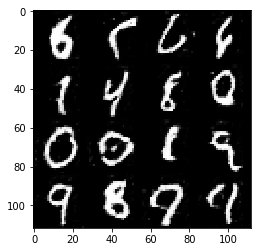

Epochs 3/5 Discrim Loss: 0.3162 Gen Loss: 1.8138
Epochs 3/5 Discrim Loss: 0.2844 Gen Loss: 2.0446
Epochs 3/5 Discrim Loss: 0.2007 Gen Loss: 2.3292
Epochs 3/5 Discrim Loss: 0.1445 Gen Loss: 2.6529
Epochs 3/5 Discrim Loss: 0.1710 Gen Loss: 2.5016


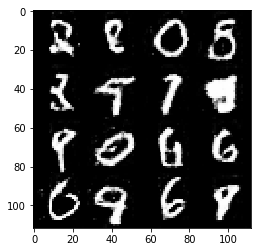

Epochs 3/5 Discrim Loss: 0.2666 Gen Loss: 1.9216
Epochs 3/5 Discrim Loss: 0.3084 Gen Loss: 1.7678
Epochs 3/5 Discrim Loss: 0.1730 Gen Loss: 2.3022
Epochs 3/5 Discrim Loss: 1.1720 Gen Loss: 0.5694
Epochs 3/5 Discrim Loss: 0.3825 Gen Loss: 3.3705


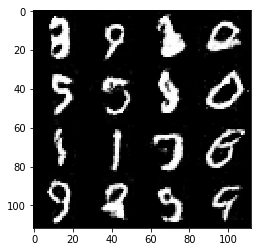

Epochs 3/5 Discrim Loss: 0.1865 Gen Loss: 2.4964
Epochs 3/5 Discrim Loss: 0.2558 Gen Loss: 1.9922
Epochs 3/5 Discrim Loss: 0.2034 Gen Loss: 2.4047
Epochs 3/5 Discrim Loss: 0.1687 Gen Loss: 2.5946
Epochs 3/5 Discrim Loss: 0.3394 Gen Loss: 1.7715


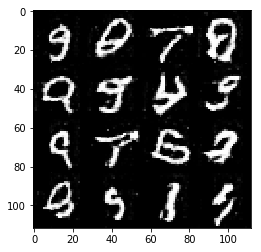

Epochs 3/5 Discrim Loss: 0.2448 Gen Loss: 2.0813
Epochs 3/5 Discrim Loss: 0.1989 Gen Loss: 2.2627
Epochs 3/5 Discrim Loss: 0.6690 Gen Loss: 1.0684
Epochs 3/5 Discrim Loss: 0.3548 Gen Loss: 1.6886
Epochs 3/5 Discrim Loss: 0.2081 Gen Loss: 2.2440


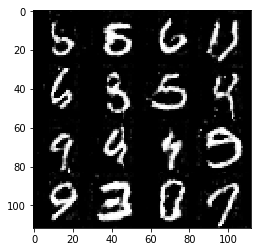

Epochs 3/5 Discrim Loss: 0.1853 Gen Loss: 2.3087
Epochs 3/5 Discrim Loss: 0.3979 Gen Loss: 1.5814
Epochs 3/5 Discrim Loss: 0.1189 Gen Loss: 2.9077
Epochs 3/5 Discrim Loss: 0.1781 Gen Loss: 2.3793
Epochs 3/5 Discrim Loss: 0.2179 Gen Loss: 2.1556


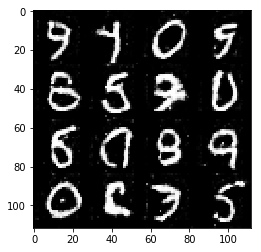

Epochs 4/5 Discrim Loss: 0.1474 Gen Loss: 2.7410
Epochs 4/5 Discrim Loss: 0.1281 Gen Loss: 2.6542
Epochs 4/5 Discrim Loss: 0.1773 Gen Loss: 2.3366
Epochs 4/5 Discrim Loss: 0.3091 Gen Loss: 1.8517
Epochs 4/5 Discrim Loss: 0.1213 Gen Loss: 2.9593


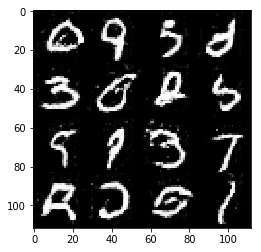

Epochs 4/5 Discrim Loss: 0.1988 Gen Loss: 2.3618
Epochs 4/5 Discrim Loss: 0.2108 Gen Loss: 2.1670
Epochs 4/5 Discrim Loss: 0.1463 Gen Loss: 2.7319
Epochs 4/5 Discrim Loss: 0.0829 Gen Loss: 3.4706
Epochs 4/5 Discrim Loss: 0.1463 Gen Loss: 2.6497


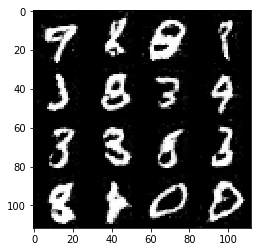

Epochs 4/5 Discrim Loss: 0.2105 Gen Loss: 2.4418
Epochs 4/5 Discrim Loss: 0.6235 Gen Loss: 1.2297
Epochs 4/5 Discrim Loss: 1.2421 Gen Loss: 0.7487
Epochs 4/5 Discrim Loss: 0.5309 Gen Loss: 1.5774
Epochs 4/5 Discrim Loss: 1.1087 Gen Loss: 0.6877


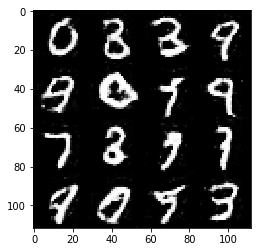

Epochs 4/5 Discrim Loss: 0.2589 Gen Loss: 2.3074
Epochs 4/5 Discrim Loss: 0.3639 Gen Loss: 1.7274
Epochs 4/5 Discrim Loss: 0.3042 Gen Loss: 1.8966
Epochs 4/5 Discrim Loss: 0.2689 Gen Loss: 2.0625
Epochs 4/5 Discrim Loss: 0.2033 Gen Loss: 2.3096


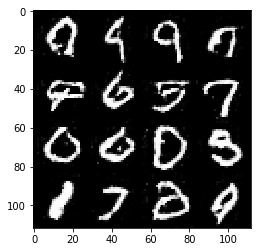

Epochs 4/5 Discrim Loss: 0.2927 Gen Loss: 1.9573
Epochs 4/5 Discrim Loss: 0.2165 Gen Loss: 2.2593
Epochs 4/5 Discrim Loss: 0.1260 Gen Loss: 2.8097
Epochs 4/5 Discrim Loss: 0.2641 Gen Loss: 1.9730
Epochs 4/5 Discrim Loss: 0.2134 Gen Loss: 2.2942


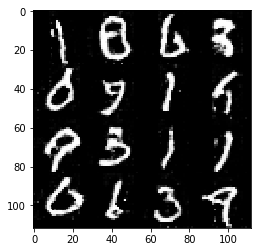

Epochs 4/5 Discrim Loss: 0.1459 Gen Loss: 3.0610
Epochs 4/5 Discrim Loss: 0.1944 Gen Loss: 2.4776
Epochs 4/5 Discrim Loss: 0.1755 Gen Loss: 2.3733
Epochs 4/5 Discrim Loss: 0.3016 Gen Loss: 2.1242
Epochs 4/5 Discrim Loss: 0.2945 Gen Loss: 1.9624


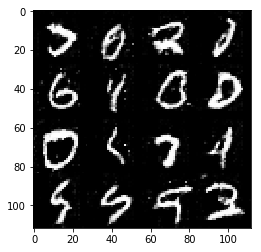

Epochs 4/5 Discrim Loss: 0.1683 Gen Loss: 2.4363
Epochs 4/5 Discrim Loss: 0.1987 Gen Loss: 2.2263
Epochs 4/5 Discrim Loss: 0.2103 Gen Loss: 2.2801
Epochs 4/5 Discrim Loss: 0.2487 Gen Loss: 2.0313
Epochs 4/5 Discrim Loss: 0.2917 Gen Loss: 1.9539


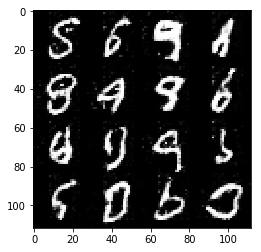

Epochs 4/5 Discrim Loss: 0.2816 Gen Loss: 1.8360
Epochs 4/5 Discrim Loss: 0.1736 Gen Loss: 2.4230
Epochs 4/5 Discrim Loss: 0.3296 Gen Loss: 1.7573
Epochs 4/5 Discrim Loss: 0.2484 Gen Loss: 3.4464
Epochs 4/5 Discrim Loss: 0.8290 Gen Loss: 0.8278


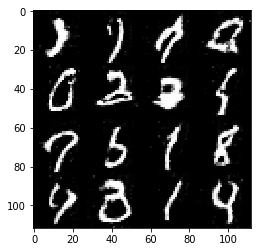

Epochs 4/5 Discrim Loss: 0.3609 Gen Loss: 1.9867
Epochs 4/5 Discrim Loss: 0.3152 Gen Loss: 1.9880
Epochs 4/5 Discrim Loss: 0.3550 Gen Loss: 1.7648
Epochs 4/5 Discrim Loss: 0.2508 Gen Loss: 2.0077
Epochs 4/5 Discrim Loss: 0.2444 Gen Loss: 2.1578


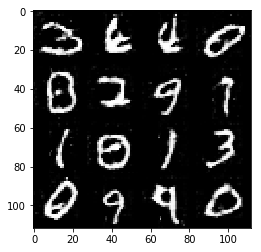

Epochs 4/5 Discrim Loss: 0.3047 Gen Loss: 1.7231
Epochs 4/5 Discrim Loss: 0.1712 Gen Loss: 2.5745
Epochs 4/5 Discrim Loss: 0.1993 Gen Loss: 2.2760
Epochs 4/5 Discrim Loss: 0.2482 Gen Loss: 2.2580
Epochs 4/5 Discrim Loss: 0.3368 Gen Loss: 1.8399


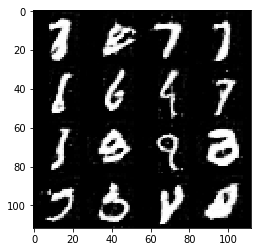

Epochs 4/5 Discrim Loss: 0.2401 Gen Loss: 1.9153
Epochs 4/5 Discrim Loss: 0.2516 Gen Loss: 2.1829
Epochs 4/5 Discrim Loss: 0.2303 Gen Loss: 2.1035
Epochs 4/5 Discrim Loss: 0.4015 Gen Loss: 1.5750
Epochs 4/5 Discrim Loss: 0.2878 Gen Loss: 1.8026


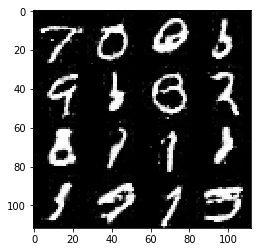

Epochs 4/5 Discrim Loss: 0.3910 Gen Loss: 1.6448
Epochs 4/5 Discrim Loss: 0.2088 Gen Loss: 2.3637
Epochs 4/5 Discrim Loss: 0.2449 Gen Loss: 2.1763
Epochs 4/5 Discrim Loss: 0.2956 Gen Loss: 1.8864
Epochs 4/5 Discrim Loss: 0.1920 Gen Loss: 2.3281


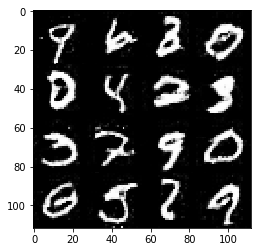

Epochs 4/5 Discrim Loss: 0.1515 Gen Loss: 2.5649
Epochs 4/5 Discrim Loss: 0.3520 Gen Loss: 1.7130
Epochs 4/5 Discrim Loss: 0.3904 Gen Loss: 1.7603
Epochs 4/5 Discrim Loss: 0.1884 Gen Loss: 2.4505
Epochs 4/5 Discrim Loss: 0.1683 Gen Loss: 2.6217


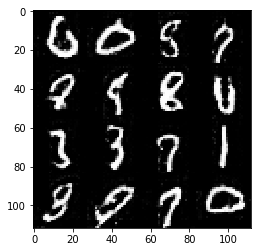

Epochs 4/5 Discrim Loss: 0.2719 Gen Loss: 2.1763
Epochs 4/5 Discrim Loss: 1.2382 Gen Loss: 0.6133
Epochs 4/5 Discrim Loss: 2.8958 Gen Loss: 5.4363
Epochs 4/5 Discrim Loss: 1.7374 Gen Loss: 5.8068
Epochs 4/5 Discrim Loss: 0.2877 Gen Loss: 2.6665


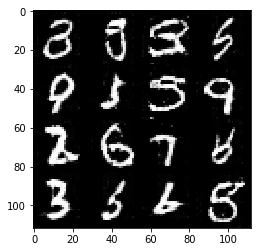

Epochs 4/5 Discrim Loss: 0.3446 Gen Loss: 2.0608
Epochs 4/5 Discrim Loss: 0.2495 Gen Loss: 2.2413
Epochs 4/5 Discrim Loss: 0.3281 Gen Loss: 1.8269
Epochs 4/5 Discrim Loss: 0.3079 Gen Loss: 1.8049
Epochs 4/5 Discrim Loss: 0.4950 Gen Loss: 1.3969


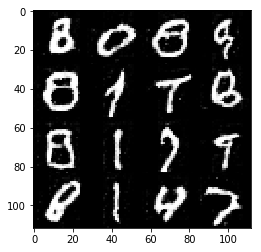

Epochs 4/5 Discrim Loss: 0.2209 Gen Loss: 2.3975
Epochs 4/5 Discrim Loss: 0.4367 Gen Loss: 1.6431
Epochs 4/5 Discrim Loss: 0.4508 Gen Loss: 1.4214
Epochs 4/5 Discrim Loss: 0.1937 Gen Loss: 2.4831
Epochs 4/5 Discrim Loss: 0.2038 Gen Loss: 2.1636


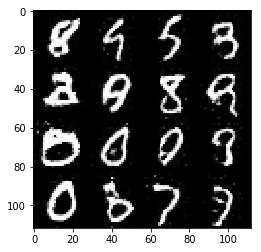

Epochs 4/5 Discrim Loss: 0.3462 Gen Loss: 1.8722
Epochs 4/5 Discrim Loss: 0.3134 Gen Loss: 1.7897
Epochs 4/5 Discrim Loss: 0.3316 Gen Loss: 1.7774
Epochs 4/5 Discrim Loss: 0.1908 Gen Loss: 2.4235
Epochs 4/5 Discrim Loss: 0.2401 Gen Loss: 2.2308


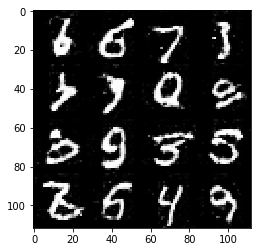

Epochs 4/5 Discrim Loss: 0.2732 Gen Loss: 2.0629
Epochs 4/5 Discrim Loss: 0.2714 Gen Loss: 1.8436
Epochs 4/5 Discrim Loss: 0.5147 Gen Loss: 1.4240
Epochs 4/5 Discrim Loss: 0.2073 Gen Loss: 2.2837
Epochs 4/5 Discrim Loss: 0.1545 Gen Loss: 2.9064


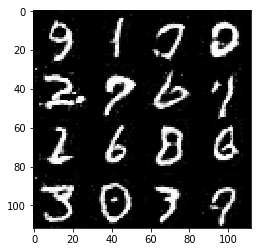

Epochs 4/5 Discrim Loss: 0.1980 Gen Loss: 2.4134
Epochs 4/5 Discrim Loss: 0.1246 Gen Loss: 2.9630
Epochs 4/5 Discrim Loss: 0.3035 Gen Loss: 1.8468
Epochs 4/5 Discrim Loss: 6.6281 Gen Loss: 9.7655


In [23]:
batch_size = 64
z_dim = 200
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epochs 0/1 Discrim Loss: 0.7159 Gen Loss: 0.8378
Epochs 0/1 Discrim Loss: 0.1632 Gen Loss: 3.0385
Epochs 0/1 Discrim Loss: 0.4200 Gen Loss: 1.3326
Epochs 0/1 Discrim Loss: 0.5916 Gen Loss: 1.3973


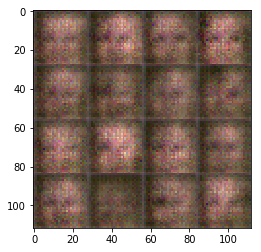

Epochs 0/1 Discrim Loss: 0.2938 Gen Loss: 3.0451
Epochs 0/1 Discrim Loss: 0.3938 Gen Loss: 1.6256
Epochs 0/1 Discrim Loss: 0.6880 Gen Loss: 1.4376
Epochs 0/1 Discrim Loss: 0.8207 Gen Loss: 3.6869
Epochs 0/1 Discrim Loss: 0.5482 Gen Loss: 2.7246


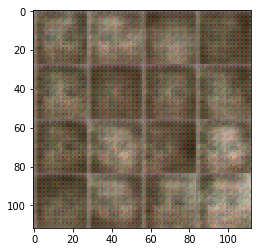

Epochs 0/1 Discrim Loss: 1.8737 Gen Loss: 0.2359
Epochs 0/1 Discrim Loss: 0.6809 Gen Loss: 3.4234
Epochs 0/1 Discrim Loss: 0.8351 Gen Loss: 0.8090
Epochs 0/1 Discrim Loss: 1.4783 Gen Loss: 0.3661
Epochs 0/1 Discrim Loss: 0.4298 Gen Loss: 2.0326


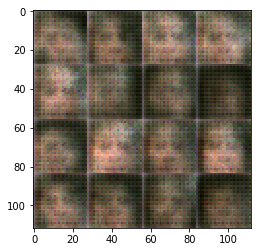

Epochs 0/1 Discrim Loss: 1.0719 Gen Loss: 0.5876
Epochs 0/1 Discrim Loss: 0.4645 Gen Loss: 3.0293
Epochs 0/1 Discrim Loss: 0.4578 Gen Loss: 1.5230
Epochs 0/1 Discrim Loss: 0.5242 Gen Loss: 1.7070
Epochs 0/1 Discrim Loss: 0.6572 Gen Loss: 3.5032


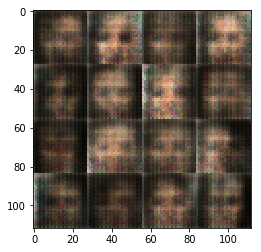

Epochs 0/1 Discrim Loss: 0.5759 Gen Loss: 1.6505
Epochs 0/1 Discrim Loss: 1.0246 Gen Loss: 0.6854
Epochs 0/1 Discrim Loss: 0.9980 Gen Loss: 0.7846
Epochs 0/1 Discrim Loss: 0.6073 Gen Loss: 1.4720
Epochs 0/1 Discrim Loss: 0.9015 Gen Loss: 0.8323


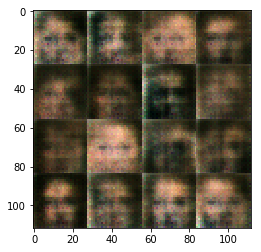

Epochs 0/1 Discrim Loss: 0.7284 Gen Loss: 1.1130
Epochs 0/1 Discrim Loss: 0.9579 Gen Loss: 1.2932
Epochs 0/1 Discrim Loss: 0.4917 Gen Loss: 2.1709
Epochs 0/1 Discrim Loss: 0.6182 Gen Loss: 1.9334
Epochs 0/1 Discrim Loss: 0.6185 Gen Loss: 1.4816


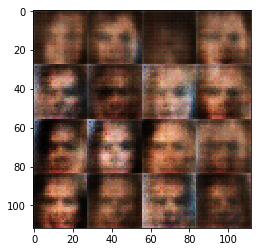

Epochs 0/1 Discrim Loss: 0.6248 Gen Loss: 1.5715
Epochs 0/1 Discrim Loss: 0.9195 Gen Loss: 0.8695
Epochs 0/1 Discrim Loss: 0.8059 Gen Loss: 2.5530
Epochs 0/1 Discrim Loss: 0.5948 Gen Loss: 1.5840
Epochs 0/1 Discrim Loss: 1.0636 Gen Loss: 0.7539


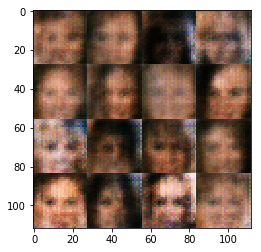

Epochs 0/1 Discrim Loss: 1.4132 Gen Loss: 0.4633
Epochs 0/1 Discrim Loss: 0.7429 Gen Loss: 1.4568
Epochs 0/1 Discrim Loss: 0.7894 Gen Loss: 1.0872
Epochs 0/1 Discrim Loss: 0.9051 Gen Loss: 1.6714
Epochs 0/1 Discrim Loss: 0.7152 Gen Loss: 1.8163


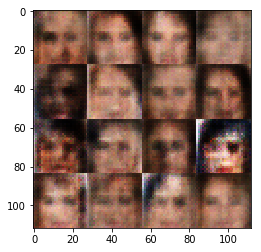

Epochs 0/1 Discrim Loss: 0.9841 Gen Loss: 0.7063
Epochs 0/1 Discrim Loss: 1.0506 Gen Loss: 0.6174
Epochs 0/1 Discrim Loss: 0.6948 Gen Loss: 1.6414
Epochs 0/1 Discrim Loss: 0.6825 Gen Loss: 1.2430
Epochs 0/1 Discrim Loss: 0.9164 Gen Loss: 0.8536


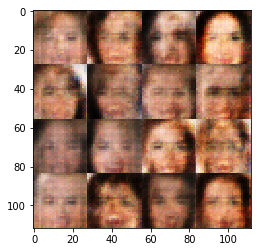

Epochs 0/1 Discrim Loss: 0.7588 Gen Loss: 1.3776
Epochs 0/1 Discrim Loss: 0.7903 Gen Loss: 1.2121
Epochs 0/1 Discrim Loss: 0.7073 Gen Loss: 1.9804
Epochs 0/1 Discrim Loss: 1.1208 Gen Loss: 0.5874
Epochs 0/1 Discrim Loss: 0.7055 Gen Loss: 1.7402


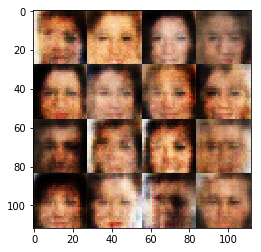

Epochs 0/1 Discrim Loss: 1.0024 Gen Loss: 0.6297
Epochs 0/1 Discrim Loss: 0.7357 Gen Loss: 1.2865
Epochs 0/1 Discrim Loss: 0.8364 Gen Loss: 2.2469
Epochs 0/1 Discrim Loss: 1.5005 Gen Loss: 0.3518
Epochs 0/1 Discrim Loss: 0.9371 Gen Loss: 0.7669


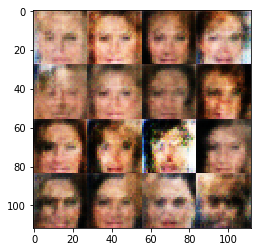

Epochs 0/1 Discrim Loss: 1.2688 Gen Loss: 0.4313
Epochs 0/1 Discrim Loss: 0.7042 Gen Loss: 1.0693
Epochs 0/1 Discrim Loss: 1.1004 Gen Loss: 0.6089
Epochs 0/1 Discrim Loss: 1.1030 Gen Loss: 0.5011
Epochs 0/1 Discrim Loss: 0.8620 Gen Loss: 1.7891


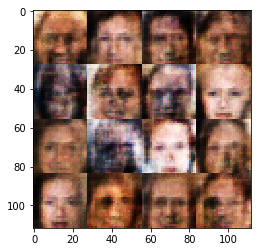

Epochs 0/1 Discrim Loss: 1.1583 Gen Loss: 0.4935
Epochs 0/1 Discrim Loss: 0.7249 Gen Loss: 1.0907
Epochs 0/1 Discrim Loss: 1.0618 Gen Loss: 0.5499
Epochs 0/1 Discrim Loss: 0.9391 Gen Loss: 0.7041
Epochs 0/1 Discrim Loss: 0.8752 Gen Loss: 0.7999


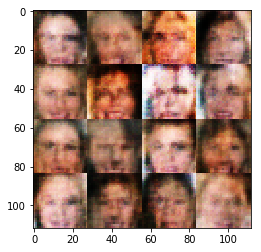

Epochs 0/1 Discrim Loss: 0.9741 Gen Loss: 0.6603
Epochs 0/1 Discrim Loss: 0.5971 Gen Loss: 1.1387
Epochs 0/1 Discrim Loss: 0.5771 Gen Loss: 2.0966
Epochs 0/1 Discrim Loss: 0.7420 Gen Loss: 1.5226
Epochs 0/1 Discrim Loss: 0.7529 Gen Loss: 1.1652


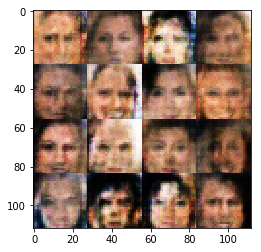

Epochs 0/1 Discrim Loss: 0.5523 Gen Loss: 2.0398
Epochs 0/1 Discrim Loss: 0.7953 Gen Loss: 2.2165
Epochs 0/1 Discrim Loss: 0.7131 Gen Loss: 1.4688
Epochs 0/1 Discrim Loss: 0.6095 Gen Loss: 1.8565
Epochs 0/1 Discrim Loss: 0.9495 Gen Loss: 0.6491


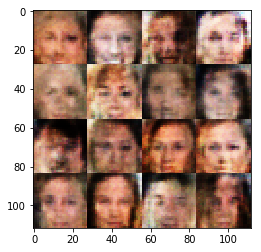

Epochs 0/1 Discrim Loss: 0.6939 Gen Loss: 1.2466
Epochs 0/1 Discrim Loss: 1.0162 Gen Loss: 0.6065
Epochs 0/1 Discrim Loss: 0.7264 Gen Loss: 1.9513
Epochs 0/1 Discrim Loss: 0.5570 Gen Loss: 1.5058
Epochs 0/1 Discrim Loss: 0.7892 Gen Loss: 0.9531


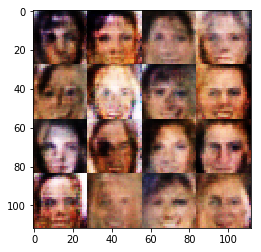

Epochs 0/1 Discrim Loss: 1.3147 Gen Loss: 0.5182
Epochs 0/1 Discrim Loss: 1.1524 Gen Loss: 2.8891
Epochs 0/1 Discrim Loss: 0.7662 Gen Loss: 1.6354
Epochs 0/1 Discrim Loss: 0.8094 Gen Loss: 0.9388
Epochs 0/1 Discrim Loss: 1.3393 Gen Loss: 0.4455


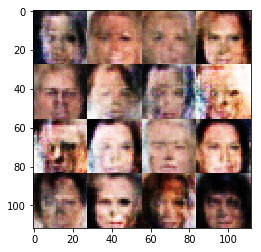

Epochs 0/1 Discrim Loss: 0.7340 Gen Loss: 1.0538
Epochs 0/1 Discrim Loss: 0.5740 Gen Loss: 1.9616
Epochs 0/1 Discrim Loss: 0.6444 Gen Loss: 1.6491
Epochs 0/1 Discrim Loss: 0.7681 Gen Loss: 1.9282
Epochs 0/1 Discrim Loss: 0.9034 Gen Loss: 2.5430


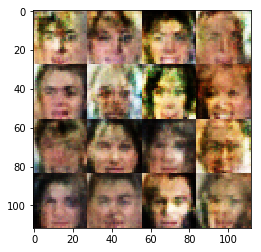

Epochs 0/1 Discrim Loss: 0.6923 Gen Loss: 1.3635
Epochs 0/1 Discrim Loss: 0.5841 Gen Loss: 1.5628
Epochs 0/1 Discrim Loss: 0.4715 Gen Loss: 1.7427
Epochs 0/1 Discrim Loss: 1.0738 Gen Loss: 2.2235
Epochs 0/1 Discrim Loss: 0.9172 Gen Loss: 3.1020


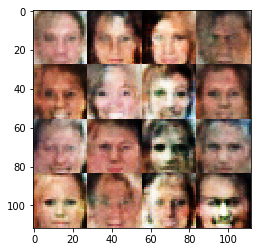

Epochs 0/1 Discrim Loss: 0.8108 Gen Loss: 0.7804
Epochs 0/1 Discrim Loss: 0.8862 Gen Loss: 2.3963
Epochs 0/1 Discrim Loss: 1.4867 Gen Loss: 0.3637
Epochs 0/1 Discrim Loss: 0.8700 Gen Loss: 1.1744
Epochs 0/1 Discrim Loss: 0.8833 Gen Loss: 0.7950


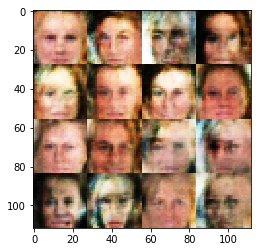

Epochs 0/1 Discrim Loss: 0.8920 Gen Loss: 0.6962
Epochs 0/1 Discrim Loss: 1.0485 Gen Loss: 0.5638
Epochs 0/1 Discrim Loss: 0.7963 Gen Loss: 0.8769
Epochs 0/1 Discrim Loss: 0.5762 Gen Loss: 1.4259
Epochs 0/1 Discrim Loss: 0.5310 Gen Loss: 2.2761


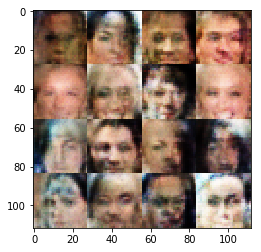

Epochs 0/1 Discrim Loss: 0.6518 Gen Loss: 1.7836
Epochs 0/1 Discrim Loss: 0.5681 Gen Loss: 1.4597
Epochs 0/1 Discrim Loss: 0.6522 Gen Loss: 2.4039
Epochs 0/1 Discrim Loss: 0.5640 Gen Loss: 1.9205
Epochs 0/1 Discrim Loss: 0.7768 Gen Loss: 0.8864


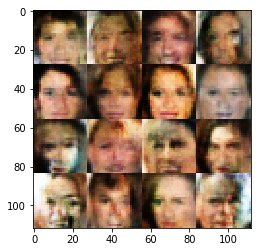

Epochs 0/1 Discrim Loss: 0.7629 Gen Loss: 1.1540
Epochs 0/1 Discrim Loss: 1.4460 Gen Loss: 3.7470
Epochs 0/1 Discrim Loss: 0.7009 Gen Loss: 1.1866
Epochs 0/1 Discrim Loss: 1.4577 Gen Loss: 3.2626
Epochs 0/1 Discrim Loss: 1.1578 Gen Loss: 0.5112


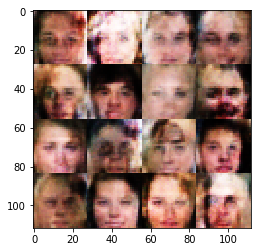

Epochs 0/1 Discrim Loss: 1.5058 Gen Loss: 0.3298
Epochs 0/1 Discrim Loss: 0.4749 Gen Loss: 1.8326
Epochs 0/1 Discrim Loss: 0.6459 Gen Loss: 1.9454
Epochs 0/1 Discrim Loss: 1.2361 Gen Loss: 2.2037
Epochs 0/1 Discrim Loss: 0.6019 Gen Loss: 2.0434


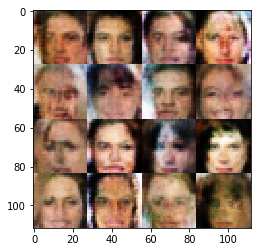

Epochs 0/1 Discrim Loss: 0.6566 Gen Loss: 1.5799
Epochs 0/1 Discrim Loss: 0.9000 Gen Loss: 0.7374
Epochs 0/1 Discrim Loss: 1.0707 Gen Loss: 0.5467
Epochs 0/1 Discrim Loss: 0.7304 Gen Loss: 1.3114
Epochs 0/1 Discrim Loss: 0.5852 Gen Loss: 1.3388


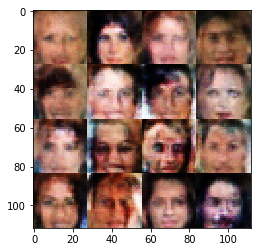

Epochs 0/1 Discrim Loss: 0.5450 Gen Loss: 1.5010
Epochs 0/1 Discrim Loss: 0.8158 Gen Loss: 1.4566
Epochs 0/1 Discrim Loss: 0.5960 Gen Loss: 1.1604
Epochs 0/1 Discrim Loss: 1.3021 Gen Loss: 3.4625
Epochs 0/1 Discrim Loss: 1.3414 Gen Loss: 0.4201


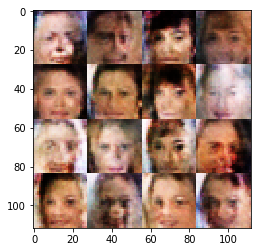

Epochs 0/1 Discrim Loss: 0.9238 Gen Loss: 0.6525
Epochs 0/1 Discrim Loss: 0.8457 Gen Loss: 0.8045
Epochs 0/1 Discrim Loss: 0.6672 Gen Loss: 1.2137
Epochs 0/1 Discrim Loss: 0.8188 Gen Loss: 1.5136
Epochs 0/1 Discrim Loss: 0.7689 Gen Loss: 1.0011


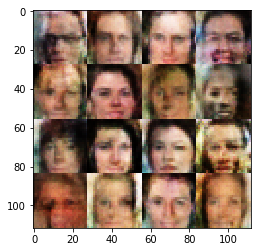

Epochs 0/1 Discrim Loss: 0.7474 Gen Loss: 1.9243
Epochs 0/1 Discrim Loss: 1.0142 Gen Loss: 0.6192
Epochs 0/1 Discrim Loss: 0.9562 Gen Loss: 0.7849
Epochs 0/1 Discrim Loss: 0.6157 Gen Loss: 1.1983
Epochs 0/1 Discrim Loss: 0.7398 Gen Loss: 0.8987


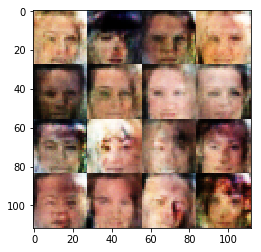

Epochs 0/1 Discrim Loss: 0.7082 Gen Loss: 1.2366
Epochs 0/1 Discrim Loss: 0.6135 Gen Loss: 2.0887
Epochs 0/1 Discrim Loss: 0.7795 Gen Loss: 2.9127
Epochs 0/1 Discrim Loss: 1.7620 Gen Loss: 0.2403
Epochs 0/1 Discrim Loss: 1.0160 Gen Loss: 1.7644


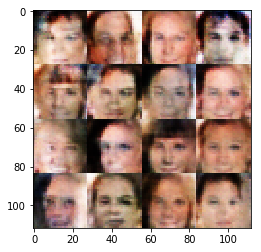

Epochs 0/1 Discrim Loss: 0.6990 Gen Loss: 1.0985
Epochs 0/1 Discrim Loss: 1.2032 Gen Loss: 0.5088
Epochs 0/1 Discrim Loss: 1.5548 Gen Loss: 0.3078
Epochs 0/1 Discrim Loss: 0.7826 Gen Loss: 0.9406
Epochs 0/1 Discrim Loss: 0.6386 Gen Loss: 1.2282


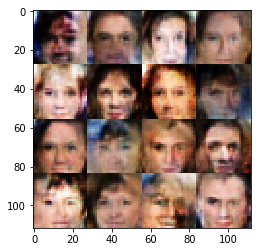

Epochs 0/1 Discrim Loss: 0.6545 Gen Loss: 1.5071
Epochs 0/1 Discrim Loss: 1.4004 Gen Loss: 0.4654
Epochs 0/1 Discrim Loss: 0.8728 Gen Loss: 1.7813
Epochs 0/1 Discrim Loss: 0.8785 Gen Loss: 1.2245
Epochs 0/1 Discrim Loss: 0.9867 Gen Loss: 1.6039


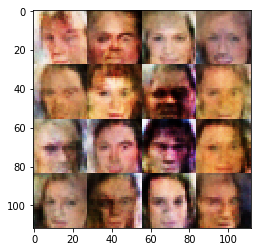

Epochs 0/1 Discrim Loss: 1.1545 Gen Loss: 0.4638
Epochs 0/1 Discrim Loss: 0.6213 Gen Loss: 2.9494
Epochs 0/1 Discrim Loss: 1.1633 Gen Loss: 0.5487
Epochs 0/1 Discrim Loss: 0.8892 Gen Loss: 0.7860
Epochs 0/1 Discrim Loss: 1.0645 Gen Loss: 0.5531


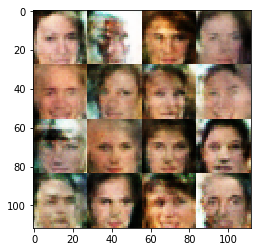

Epochs 0/1 Discrim Loss: 0.7193 Gen Loss: 1.0853
Epochs 0/1 Discrim Loss: 0.6913 Gen Loss: 1.1477
Epochs 0/1 Discrim Loss: 0.4952 Gen Loss: 1.5686
Epochs 0/1 Discrim Loss: 1.1302 Gen Loss: 1.6335
Epochs 0/1 Discrim Loss: 0.9693 Gen Loss: 0.7001


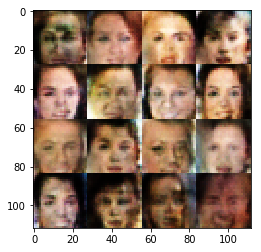

Epochs 0/1 Discrim Loss: 1.4803 Gen Loss: 0.3439
Epochs 0/1 Discrim Loss: 0.8912 Gen Loss: 0.8338
Epochs 0/1 Discrim Loss: 0.7410 Gen Loss: 1.0340
Epochs 0/1 Discrim Loss: 0.7502 Gen Loss: 0.8979
Epochs 0/1 Discrim Loss: 0.7949 Gen Loss: 1.2625


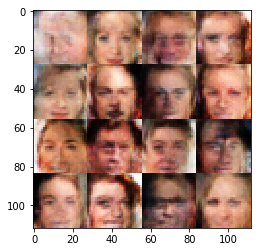

Epochs 0/1 Discrim Loss: 1.0465 Gen Loss: 3.1918
Epochs 0/1 Discrim Loss: 0.9156 Gen Loss: 0.9062
Epochs 0/1 Discrim Loss: 0.8614 Gen Loss: 0.8074
Epochs 0/1 Discrim Loss: 0.9236 Gen Loss: 0.7670
Epochs 0/1 Discrim Loss: 0.9933 Gen Loss: 1.9278


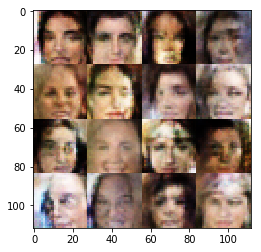

Epochs 0/1 Discrim Loss: 0.6095 Gen Loss: 1.3517
Epochs 0/1 Discrim Loss: 0.8809 Gen Loss: 1.8366
Epochs 0/1 Discrim Loss: 0.6501 Gen Loss: 1.1348
Epochs 0/1 Discrim Loss: 0.6830 Gen Loss: 1.9809
Epochs 0/1 Discrim Loss: 0.5504 Gen Loss: 1.3230


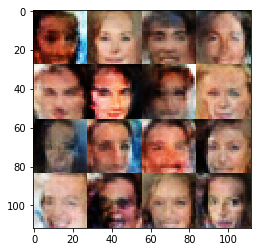

Epochs 0/1 Discrim Loss: 0.5168 Gen Loss: 1.5050
Epochs 0/1 Discrim Loss: 0.8524 Gen Loss: 0.7578
Epochs 0/1 Discrim Loss: 0.4951 Gen Loss: 2.1052
Epochs 0/1 Discrim Loss: 0.9373 Gen Loss: 0.6559
Epochs 0/1 Discrim Loss: 0.8012 Gen Loss: 0.7930


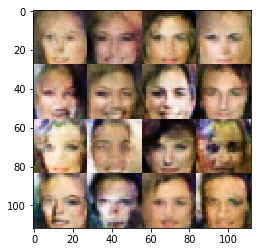

Epochs 0/1 Discrim Loss: 0.7604 Gen Loss: 2.5893
Epochs 0/1 Discrim Loss: 1.3854 Gen Loss: 0.3671
Epochs 0/1 Discrim Loss: 0.9206 Gen Loss: 0.7047
Epochs 0/1 Discrim Loss: 1.1101 Gen Loss: 0.5240
Epochs 0/1 Discrim Loss: 0.5251 Gen Loss: 1.7290


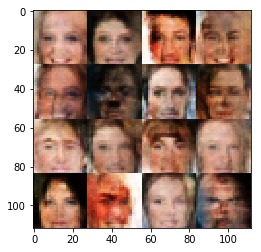

Epochs 0/1 Discrim Loss: 0.8439 Gen Loss: 0.9921
Epochs 0/1 Discrim Loss: 0.7530 Gen Loss: 0.9672
Epochs 0/1 Discrim Loss: 1.0494 Gen Loss: 0.5764
Epochs 0/1 Discrim Loss: 0.9826 Gen Loss: 2.5351
Epochs 0/1 Discrim Loss: 0.6748 Gen Loss: 2.3425


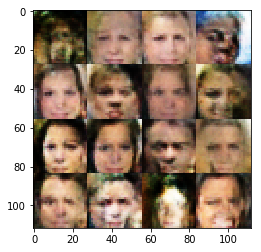

Epochs 0/1 Discrim Loss: 0.6403 Gen Loss: 1.5523
Epochs 0/1 Discrim Loss: 0.9898 Gen Loss: 0.6753
Epochs 0/1 Discrim Loss: 1.1153 Gen Loss: 0.5893
Epochs 0/1 Discrim Loss: 1.0608 Gen Loss: 0.5910
Epochs 0/1 Discrim Loss: 1.2119 Gen Loss: 0.5237


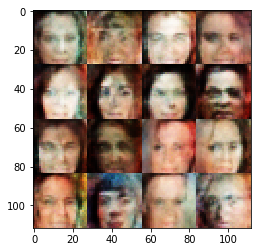

Epochs 0/1 Discrim Loss: 0.8461 Gen Loss: 0.9037
Epochs 0/1 Discrim Loss: 0.6671 Gen Loss: 1.1184
Epochs 0/1 Discrim Loss: 0.8635 Gen Loss: 0.9259
Epochs 0/1 Discrim Loss: 1.0526 Gen Loss: 0.6903
Epochs 0/1 Discrim Loss: 1.3843 Gen Loss: 0.3770


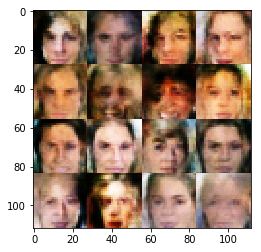

Epochs 0/1 Discrim Loss: 0.8876 Gen Loss: 1.5678
Epochs 0/1 Discrim Loss: 0.5277 Gen Loss: 1.5914
Epochs 0/1 Discrim Loss: 0.7732 Gen Loss: 0.8932
Epochs 0/1 Discrim Loss: 0.6129 Gen Loss: 1.8212
Epochs 0/1 Discrim Loss: 0.5883 Gen Loss: 1.6182


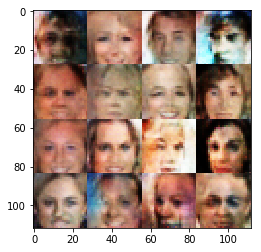

Epochs 0/1 Discrim Loss: 0.7068 Gen Loss: 2.1565
Epochs 0/1 Discrim Loss: 0.6772 Gen Loss: 1.5735
Epochs 0/1 Discrim Loss: 0.6538 Gen Loss: 1.4195
Epochs 0/1 Discrim Loss: 0.4037 Gen Loss: 2.4271
Epochs 0/1 Discrim Loss: 1.3366 Gen Loss: 0.4172


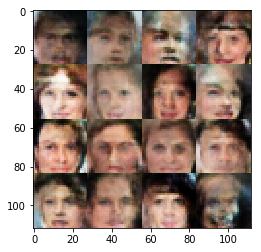

Epochs 0/1 Discrim Loss: 0.6403 Gen Loss: 1.7046
Epochs 0/1 Discrim Loss: 0.6368 Gen Loss: 1.2910
Epochs 0/1 Discrim Loss: 0.3983 Gen Loss: 1.7897
Epochs 0/1 Discrim Loss: 1.0650 Gen Loss: 0.5559
Epochs 0/1 Discrim Loss: 0.7062 Gen Loss: 0.9427


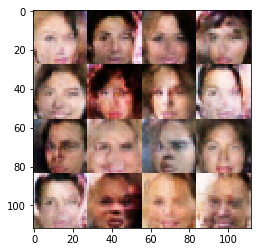

Epochs 0/1 Discrim Loss: 1.1500 Gen Loss: 0.5416
Epochs 0/1 Discrim Loss: 0.6644 Gen Loss: 1.1293
Epochs 0/1 Discrim Loss: 0.8222 Gen Loss: 0.9254
Epochs 0/1 Discrim Loss: 1.0718 Gen Loss: 2.3610
Epochs 0/1 Discrim Loss: 0.6939 Gen Loss: 0.9525


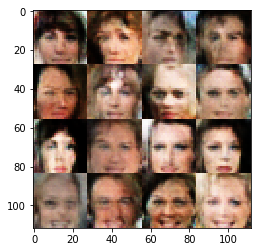

Epochs 0/1 Discrim Loss: 0.9984 Gen Loss: 0.6388
Epochs 0/1 Discrim Loss: 1.1557 Gen Loss: 0.5905
Epochs 0/1 Discrim Loss: 0.9233 Gen Loss: 0.6624
Epochs 0/1 Discrim Loss: 0.5125 Gen Loss: 3.2926
Epochs 0/1 Discrim Loss: 1.0556 Gen Loss: 0.7742


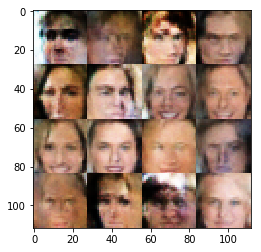

Epochs 0/1 Discrim Loss: 0.6992 Gen Loss: 1.3908
Epochs 0/1 Discrim Loss: 0.9378 Gen Loss: 0.7564
Epochs 0/1 Discrim Loss: 0.4595 Gen Loss: 1.4329
Epochs 0/1 Discrim Loss: 0.7588 Gen Loss: 1.0163
Epochs 0/1 Discrim Loss: 1.6646 Gen Loss: 0.3183


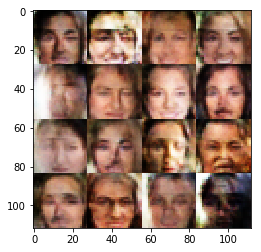

Epochs 0/1 Discrim Loss: 0.6663 Gen Loss: 1.1953
Epochs 0/1 Discrim Loss: 0.5666 Gen Loss: 1.4073
Epochs 0/1 Discrim Loss: 0.7700 Gen Loss: 0.8535
Epochs 0/1 Discrim Loss: 0.7553 Gen Loss: 0.8141
Epochs 0/1 Discrim Loss: 1.1324 Gen Loss: 0.5658


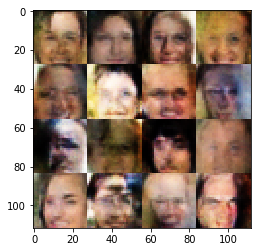

Epochs 0/1 Discrim Loss: 1.5222 Gen Loss: 3.5507
Epochs 0/1 Discrim Loss: 0.9046 Gen Loss: 0.6955
Epochs 0/1 Discrim Loss: 1.0204 Gen Loss: 3.4193
Epochs 0/1 Discrim Loss: 0.7047 Gen Loss: 1.0673
Epochs 0/1 Discrim Loss: 0.8879 Gen Loss: 0.8242


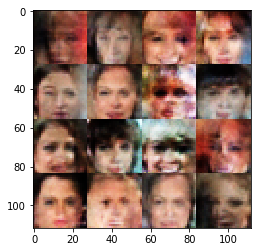

Epochs 0/1 Discrim Loss: 0.8201 Gen Loss: 0.8498
Epochs 0/1 Discrim Loss: 0.6297 Gen Loss: 1.0475
Epochs 0/1 Discrim Loss: 1.3981 Gen Loss: 0.3715
Epochs 0/1 Discrim Loss: 0.9700 Gen Loss: 0.6450
Epochs 0/1 Discrim Loss: 1.0054 Gen Loss: 0.6374


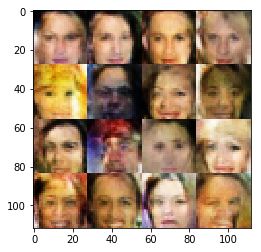

Epochs 0/1 Discrim Loss: 0.5567 Gen Loss: 2.4725
Epochs 0/1 Discrim Loss: 0.5974 Gen Loss: 1.5989
Epochs 0/1 Discrim Loss: 0.8357 Gen Loss: 0.8355
Epochs 0/1 Discrim Loss: 0.7306 Gen Loss: 0.9060
Epochs 0/1 Discrim Loss: 1.0223 Gen Loss: 0.5561


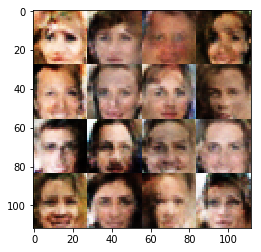

Epochs 0/1 Discrim Loss: 0.8260 Gen Loss: 0.7138
Epochs 0/1 Discrim Loss: 0.8430 Gen Loss: 2.8995
Epochs 0/1 Discrim Loss: 1.3818 Gen Loss: 0.4014
Epochs 0/1 Discrim Loss: 1.1998 Gen Loss: 0.4703
Epochs 0/1 Discrim Loss: 0.7498 Gen Loss: 1.1550


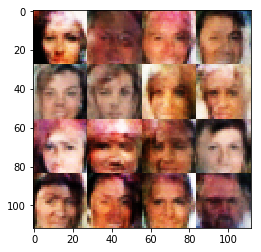

Epochs 0/1 Discrim Loss: 0.7314 Gen Loss: 2.2362
Epochs 0/1 Discrim Loss: 1.7714 Gen Loss: 0.2505
Epochs 0/1 Discrim Loss: 0.7848 Gen Loss: 0.9872
Epochs 0/1 Discrim Loss: 0.7187 Gen Loss: 1.0142
Epochs 0/1 Discrim Loss: 0.6816 Gen Loss: 1.0296


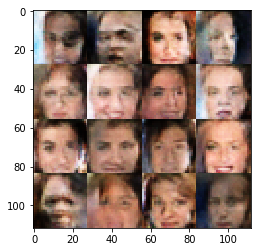

Epochs 0/1 Discrim Loss: 0.7996 Gen Loss: 0.8212
Epochs 0/1 Discrim Loss: 0.6182 Gen Loss: 1.2900
Epochs 0/1 Discrim Loss: 0.7067 Gen Loss: 1.8848
Epochs 0/1 Discrim Loss: 0.4187 Gen Loss: 3.5673
Epochs 0/1 Discrim Loss: 1.3004 Gen Loss: 0.4723


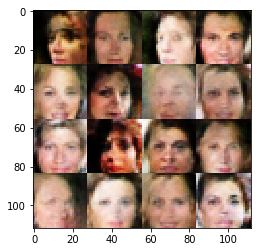

Epochs 0/1 Discrim Loss: 0.8782 Gen Loss: 0.8624
Epochs 0/1 Discrim Loss: 1.0095 Gen Loss: 0.6410
Epochs 0/1 Discrim Loss: 1.3518 Gen Loss: 0.4378
Epochs 0/1 Discrim Loss: 0.9280 Gen Loss: 0.6602
Epochs 0/1 Discrim Loss: 0.8121 Gen Loss: 1.2775


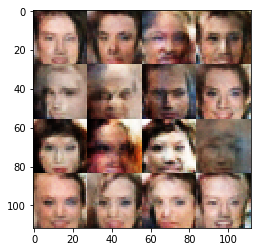

Epochs 0/1 Discrim Loss: 0.5439 Gen Loss: 1.3799
Epochs 0/1 Discrim Loss: 0.5791 Gen Loss: 1.5570
Epochs 0/1 Discrim Loss: 0.7856 Gen Loss: 0.7914
Epochs 0/1 Discrim Loss: 0.5765 Gen Loss: 1.1131
Epochs 0/1 Discrim Loss: 1.4510 Gen Loss: 2.6868


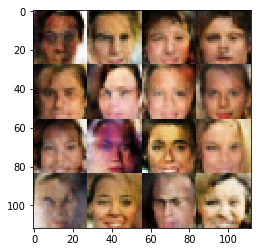

Epochs 0/1 Discrim Loss: 0.7546 Gen Loss: 1.0288
Epochs 0/1 Discrim Loss: 0.5902 Gen Loss: 1.3336
Epochs 0/1 Discrim Loss: 0.9248 Gen Loss: 2.3623
Epochs 0/1 Discrim Loss: 0.8281 Gen Loss: 0.8094
Epochs 0/1 Discrim Loss: 0.8776 Gen Loss: 0.7487


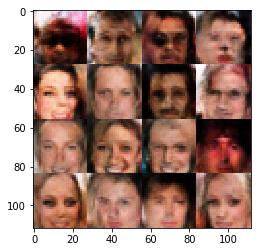

Epochs 0/1 Discrim Loss: 0.7870 Gen Loss: 0.7866
Epochs 0/1 Discrim Loss: 0.7521 Gen Loss: 0.9613
Epochs 0/1 Discrim Loss: 0.7208 Gen Loss: 0.9380
Epochs 0/1 Discrim Loss: 1.4553 Gen Loss: 0.3280
Epochs 0/1 Discrim Loss: 0.8232 Gen Loss: 0.7947


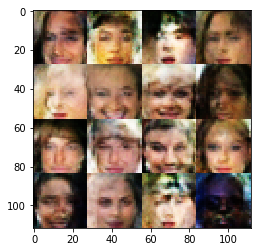

Epochs 0/1 Discrim Loss: 0.5318 Gen Loss: 2.6986
Epochs 0/1 Discrim Loss: 0.6133 Gen Loss: 1.7050
Epochs 0/1 Discrim Loss: 0.5457 Gen Loss: 2.2672
Epochs 0/1 Discrim Loss: 0.5396 Gen Loss: 1.7988
Epochs 0/1 Discrim Loss: 0.5645 Gen Loss: 1.3301


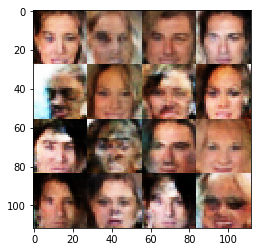

Epochs 0/1 Discrim Loss: 0.4681 Gen Loss: 1.7742
Epochs 0/1 Discrim Loss: 0.8865 Gen Loss: 0.7117
Epochs 0/1 Discrim Loss: 0.6091 Gen Loss: 1.2412
Epochs 0/1 Discrim Loss: 0.7982 Gen Loss: 0.9160
Epochs 0/1 Discrim Loss: 0.5666 Gen Loss: 1.7428


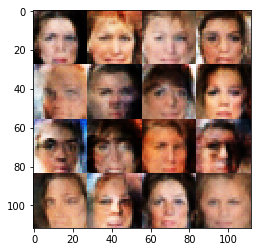

Epochs 0/1 Discrim Loss: 1.6348 Gen Loss: 4.0130
Epochs 0/1 Discrim Loss: 1.1953 Gen Loss: 0.6300
Epochs 0/1 Discrim Loss: 0.9760 Gen Loss: 0.6043
Epochs 0/1 Discrim Loss: 0.4967 Gen Loss: 1.3491
Epochs 0/1 Discrim Loss: 1.0833 Gen Loss: 2.8477


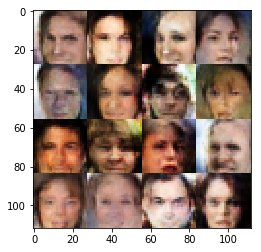

Epochs 0/1 Discrim Loss: 0.5778 Gen Loss: 1.7942
Epochs 0/1 Discrim Loss: 0.8400 Gen Loss: 1.0082
Epochs 0/1 Discrim Loss: 0.6969 Gen Loss: 1.3535
Epochs 0/1 Discrim Loss: 0.6879 Gen Loss: 1.3421
Epochs 0/1 Discrim Loss: 0.5628 Gen Loss: 1.2330


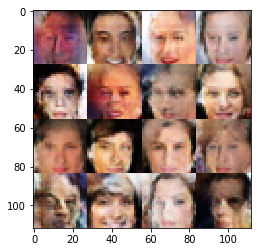

Epochs 0/1 Discrim Loss: 0.9965 Gen Loss: 0.8173
Epochs 0/1 Discrim Loss: 0.4967 Gen Loss: 1.3428
Epochs 0/1 Discrim Loss: 0.7678 Gen Loss: 0.9091
Epochs 0/1 Discrim Loss: 1.3071 Gen Loss: 0.3830
Epochs 0/1 Discrim Loss: 0.7795 Gen Loss: 0.9099


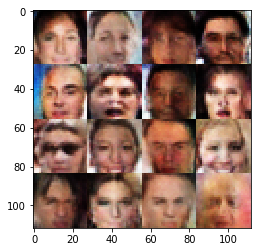

Epochs 0/1 Discrim Loss: 0.5186 Gen Loss: 1.7575
Epochs 0/1 Discrim Loss: 0.9574 Gen Loss: 0.6817
Epochs 0/1 Discrim Loss: 0.6337 Gen Loss: 1.1119
Epochs 0/1 Discrim Loss: 1.1093 Gen Loss: 0.5930
Epochs 0/1 Discrim Loss: 1.6837 Gen Loss: 0.3227


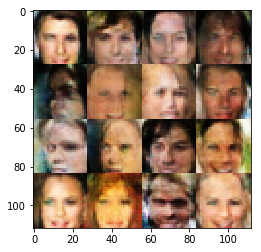

Epochs 0/1 Discrim Loss: 0.4560 Gen Loss: 1.3677
Epochs 0/1 Discrim Loss: 0.8461 Gen Loss: 0.8520
Epochs 0/1 Discrim Loss: 0.4573 Gen Loss: 1.8132
Epochs 0/1 Discrim Loss: 0.5196 Gen Loss: 1.3664
Epochs 0/1 Discrim Loss: 0.9319 Gen Loss: 0.7036


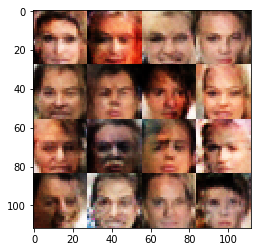

Epochs 0/1 Discrim Loss: 0.6433 Gen Loss: 0.9964
Epochs 0/1 Discrim Loss: 0.5681 Gen Loss: 3.2385
Epochs 0/1 Discrim Loss: 0.5446 Gen Loss: 1.4372
Epochs 0/1 Discrim Loss: 0.5223 Gen Loss: 2.6039
Epochs 0/1 Discrim Loss: 0.6354 Gen Loss: 1.1906


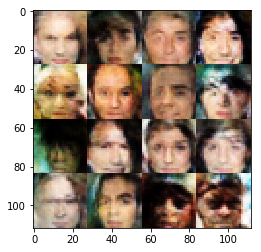

Epochs 0/1 Discrim Loss: 0.4568 Gen Loss: 2.2626
Epochs 0/1 Discrim Loss: 0.6841 Gen Loss: 0.9679
Epochs 0/1 Discrim Loss: 0.9039 Gen Loss: 0.6932
Epochs 0/1 Discrim Loss: 2.2562 Gen Loss: 0.1560
Epochs 0/1 Discrim Loss: 1.0724 Gen Loss: 0.5711


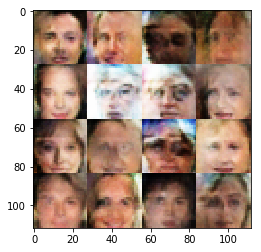

Epochs 0/1 Discrim Loss: 0.6659 Gen Loss: 1.0772
Epochs 0/1 Discrim Loss: 0.9145 Gen Loss: 0.7505
Epochs 0/1 Discrim Loss: 0.5017 Gen Loss: 1.7908
Epochs 0/1 Discrim Loss: 0.6545 Gen Loss: 1.1730
Epochs 0/1 Discrim Loss: 0.8095 Gen Loss: 0.7862


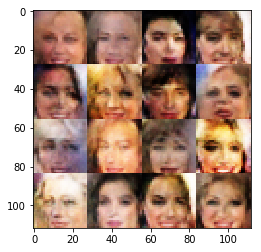

Epochs 0/1 Discrim Loss: 0.8705 Gen Loss: 0.7172
Epochs 0/1 Discrim Loss: 1.2418 Gen Loss: 0.4538
Epochs 0/1 Discrim Loss: 0.5956 Gen Loss: 1.4204
Epochs 0/1 Discrim Loss: 0.7315 Gen Loss: 0.8968
Epochs 0/1 Discrim Loss: 0.4806 Gen Loss: 2.1283


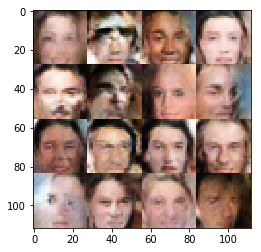

Epochs 0/1 Discrim Loss: 0.6169 Gen Loss: 1.0680
Epochs 0/1 Discrim Loss: 0.6983 Gen Loss: 1.7119
Epochs 0/1 Discrim Loss: 0.7623 Gen Loss: 0.8707
Epochs 0/1 Discrim Loss: 1.9313 Gen Loss: 3.5429
Epochs 0/1 Discrim Loss: 0.7739 Gen Loss: 1.7987


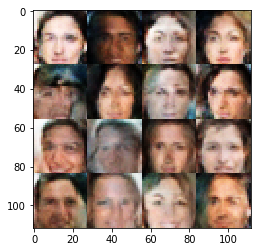

Epochs 0/1 Discrim Loss: 1.6487 Gen Loss: 0.3362
Epochs 0/1 Discrim Loss: 1.3166 Gen Loss: 0.4301
Epochs 0/1 Discrim Loss: 0.7848 Gen Loss: 0.8450
Epochs 0/1 Discrim Loss: 0.6330 Gen Loss: 0.9751
Epochs 0/1 Discrim Loss: 0.9779 Gen Loss: 0.6101


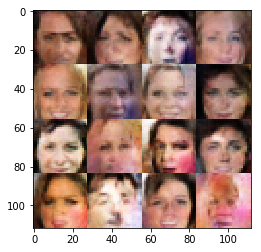

Epochs 0/1 Discrim Loss: 1.0229 Gen Loss: 1.1895
Epochs 0/1 Discrim Loss: 0.9279 Gen Loss: 1.6751
Epochs 0/1 Discrim Loss: 1.1992 Gen Loss: 0.6489
Epochs 0/1 Discrim Loss: 1.1740 Gen Loss: 0.4963
Epochs 0/1 Discrim Loss: 0.4840 Gen Loss: 1.5061


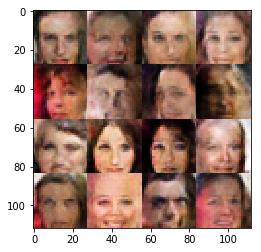

Epochs 0/1 Discrim Loss: 0.7616 Gen Loss: 0.9588
Epochs 0/1 Discrim Loss: 0.4810 Gen Loss: 2.1818
Epochs 0/1 Discrim Loss: 0.2754 Gen Loss: 2.0340
Epochs 0/1 Discrim Loss: 0.9199 Gen Loss: 0.7116
Epochs 0/1 Discrim Loss: 0.6040 Gen Loss: 1.2442


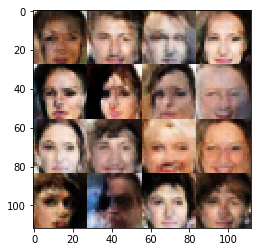

Epochs 0/1 Discrim Loss: 0.4178 Gen Loss: 1.9135
Epochs 0/1 Discrim Loss: 1.0131 Gen Loss: 0.6045
Epochs 0/1 Discrim Loss: 0.4715 Gen Loss: 1.8051
Epochs 0/1 Discrim Loss: 0.5688 Gen Loss: 1.6838
Epochs 0/1 Discrim Loss: 0.8291 Gen Loss: 1.9463


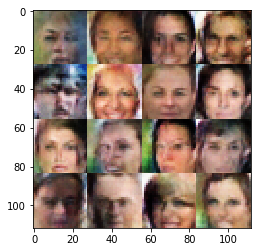

Epochs 0/1 Discrim Loss: 0.4489 Gen Loss: 1.3915
Epochs 0/1 Discrim Loss: 1.0925 Gen Loss: 0.5310
Epochs 0/1 Discrim Loss: 0.5184 Gen Loss: 1.9581
Epochs 0/1 Discrim Loss: 0.4958 Gen Loss: 2.5762
Epochs 0/1 Discrim Loss: 0.9858 Gen Loss: 0.6645


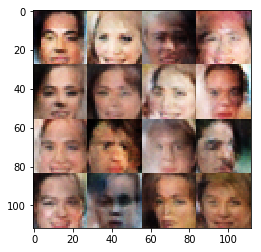

Epochs 0/1 Discrim Loss: 0.6141 Gen Loss: 1.4769
Epochs 0/1 Discrim Loss: 1.0023 Gen Loss: 0.5889
Epochs 0/1 Discrim Loss: 0.7699 Gen Loss: 0.8148
Epochs 0/1 Discrim Loss: 0.4794 Gen Loss: 1.5415
Epochs 0/1 Discrim Loss: 1.3371 Gen Loss: 0.4003


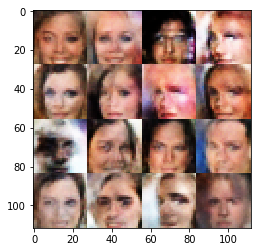

Epochs 0/1 Discrim Loss: 1.1027 Gen Loss: 0.5055
Epochs 0/1 Discrim Loss: 1.6946 Gen Loss: 0.2565
Epochs 0/1 Discrim Loss: 0.4486 Gen Loss: 1.8289
Epochs 0/1 Discrim Loss: 0.9473 Gen Loss: 0.7522
Epochs 0/1 Discrim Loss: 0.7655 Gen Loss: 1.1384


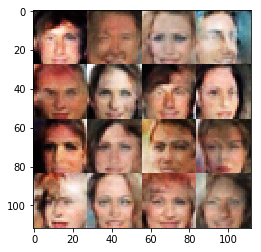

Epochs 0/1 Discrim Loss: 1.2071 Gen Loss: 2.8375
Epochs 0/1 Discrim Loss: 0.7418 Gen Loss: 0.9723
Epochs 0/1 Discrim Loss: 0.8133 Gen Loss: 2.0196
Epochs 0/1 Discrim Loss: 0.8084 Gen Loss: 2.6264
Epochs 0/1 Discrim Loss: 1.1165 Gen Loss: 0.5690


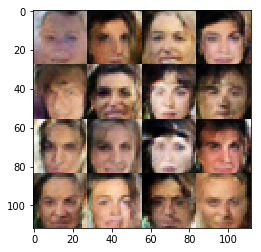

Epochs 0/1 Discrim Loss: 0.7076 Gen Loss: 1.0404
Epochs 0/1 Discrim Loss: 0.6842 Gen Loss: 0.9159
Epochs 0/1 Discrim Loss: 0.4925 Gen Loss: 2.2924
Epochs 0/1 Discrim Loss: 0.6141 Gen Loss: 1.6888
Epochs 0/1 Discrim Loss: 0.5112 Gen Loss: 1.3723


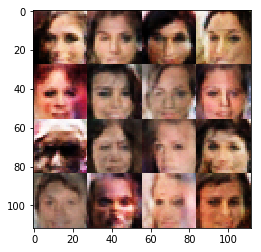

Epochs 0/1 Discrim Loss: 0.8907 Gen Loss: 3.4823
Epochs 0/1 Discrim Loss: 0.4886 Gen Loss: 1.4579
Epochs 0/1 Discrim Loss: 0.7830 Gen Loss: 1.1239
Epochs 0/1 Discrim Loss: 0.4154 Gen Loss: 2.7568
Epochs 0/1 Discrim Loss: 0.8535 Gen Loss: 0.9100


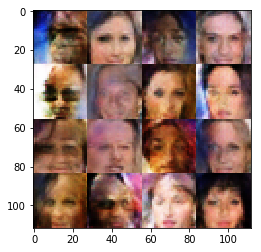

Epochs 0/1 Discrim Loss: 1.0052 Gen Loss: 2.7791
Epochs 0/1 Discrim Loss: 1.4177 Gen Loss: 0.4352
Epochs 0/1 Discrim Loss: 0.9792 Gen Loss: 0.6253
Epochs 0/1 Discrim Loss: 0.5058 Gen Loss: 1.4346
Epochs 0/1 Discrim Loss: 0.5029 Gen Loss: 1.3892


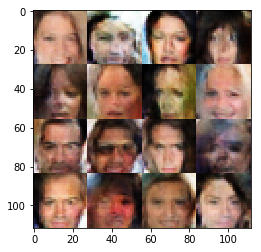

Epochs 0/1 Discrim Loss: 0.8389 Gen Loss: 0.7824
Epochs 0/1 Discrim Loss: 1.1119 Gen Loss: 0.5201
Epochs 0/1 Discrim Loss: 0.4623 Gen Loss: 1.6670
Epochs 0/1 Discrim Loss: 0.7295 Gen Loss: 0.9471
Epochs 0/1 Discrim Loss: 0.5553 Gen Loss: 1.3366


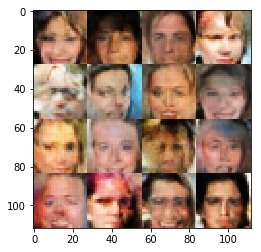

Epochs 0/1 Discrim Loss: 1.3125 Gen Loss: 0.6107
Epochs 0/1 Discrim Loss: 0.8743 Gen Loss: 0.8313
Epochs 0/1 Discrim Loss: 0.6787 Gen Loss: 0.9802
Epochs 0/1 Discrim Loss: 0.6745 Gen Loss: 1.0256
Epochs 0/1 Discrim Loss: 1.0532 Gen Loss: 0.5807


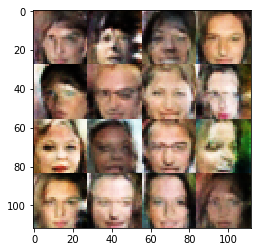

Epochs 0/1 Discrim Loss: 0.9717 Gen Loss: 0.5977
Epochs 0/1 Discrim Loss: 0.6912 Gen Loss: 1.0001
Epochs 0/1 Discrim Loss: 0.4947 Gen Loss: 1.5590
Epochs 0/1 Discrim Loss: 2.0741 Gen Loss: 0.1911
Epochs 0/1 Discrim Loss: 0.5286 Gen Loss: 1.6721


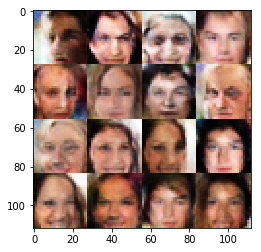

Epochs 0/1 Discrim Loss: 0.6381 Gen Loss: 1.5984
Epochs 0/1 Discrim Loss: 0.8514 Gen Loss: 2.7931
Epochs 0/1 Discrim Loss: 0.6471 Gen Loss: 1.1336
Epochs 0/1 Discrim Loss: 0.8949 Gen Loss: 0.7992
Epochs 0/1 Discrim Loss: 0.5475 Gen Loss: 1.5923


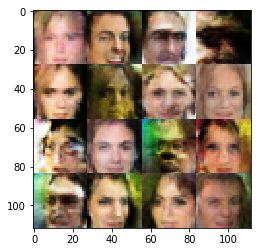

Epochs 0/1 Discrim Loss: 0.5263 Gen Loss: 1.2323
Epochs 0/1 Discrim Loss: 0.6832 Gen Loss: 1.0567
Epochs 0/1 Discrim Loss: 0.7612 Gen Loss: 0.8381
Epochs 0/1 Discrim Loss: 0.9405 Gen Loss: 0.7072
Epochs 0/1 Discrim Loss: 0.3988 Gen Loss: 2.5234


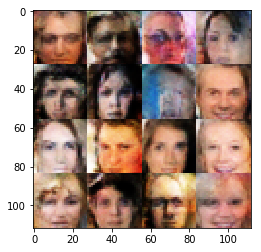

Epochs 0/1 Discrim Loss: 0.7386 Gen Loss: 0.8930
Epochs 0/1 Discrim Loss: 0.4088 Gen Loss: 2.1452
Epochs 0/1 Discrim Loss: 1.0643 Gen Loss: 0.5423
Epochs 0/1 Discrim Loss: 0.9960 Gen Loss: 2.0834
Epochs 0/1 Discrim Loss: 0.6646 Gen Loss: 1.0734


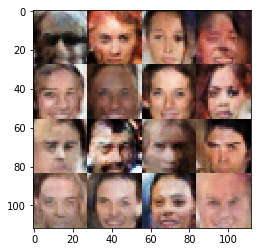

Epochs 0/1 Discrim Loss: 1.1121 Gen Loss: 0.5778
Epochs 0/1 Discrim Loss: 0.5890 Gen Loss: 1.2314
Epochs 0/1 Discrim Loss: 0.5187 Gen Loss: 1.3195
Epochs 0/1 Discrim Loss: 0.4490 Gen Loss: 1.4874
Epochs 0/1 Discrim Loss: 0.8071 Gen Loss: 2.7493


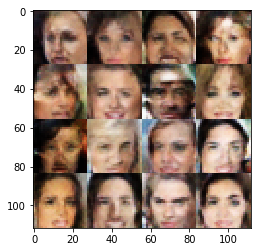

Epochs 0/1 Discrim Loss: 0.6780 Gen Loss: 1.1013
Epochs 0/1 Discrim Loss: 0.8367 Gen Loss: 0.8631
Epochs 0/1 Discrim Loss: 0.7855 Gen Loss: 0.9417
Epochs 0/1 Discrim Loss: 1.0314 Gen Loss: 0.5643
Epochs 0/1 Discrim Loss: 0.2589 Gen Loss: 2.5108


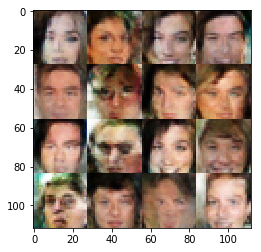

Epochs 0/1 Discrim Loss: 0.6216 Gen Loss: 1.9484
Epochs 0/1 Discrim Loss: 0.9116 Gen Loss: 0.7552
Epochs 0/1 Discrim Loss: 0.4599 Gen Loss: 1.9124
Epochs 0/1 Discrim Loss: 0.6145 Gen Loss: 1.2367
Epochs 0/1 Discrim Loss: 0.4462 Gen Loss: 1.5865


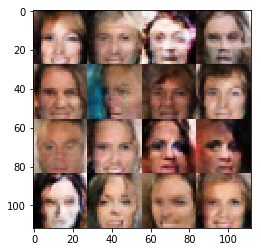

Epochs 0/1 Discrim Loss: 0.6996 Gen Loss: 1.1632
Epochs 0/1 Discrim Loss: 0.6317 Gen Loss: 1.0935
Epochs 0/1 Discrim Loss: 1.4500 Gen Loss: 3.2988
Epochs 0/1 Discrim Loss: 0.8207 Gen Loss: 0.8149
Epochs 0/1 Discrim Loss: 0.4359 Gen Loss: 1.4266


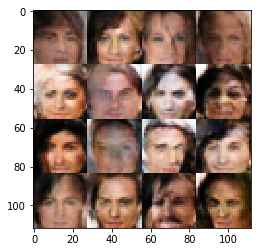

Epochs 0/1 Discrim Loss: 0.7383 Gen Loss: 1.3578
Epochs 0/1 Discrim Loss: 1.0029 Gen Loss: 0.6592
Epochs 0/1 Discrim Loss: 0.5321 Gen Loss: 1.4607
Epochs 0/1 Discrim Loss: 0.7644 Gen Loss: 0.8213
Epochs 0/1 Discrim Loss: 0.6143 Gen Loss: 1.0883


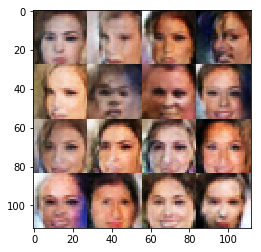

Epochs 0/1 Discrim Loss: 0.8000 Gen Loss: 0.8960
Epochs 0/1 Discrim Loss: 0.5238 Gen Loss: 2.0931
Epochs 0/1 Discrim Loss: 0.3410 Gen Loss: 2.3045
Epochs 0/1 Discrim Loss: 0.5837 Gen Loss: 1.0820
Epochs 0/1 Discrim Loss: 0.5338 Gen Loss: 1.0825


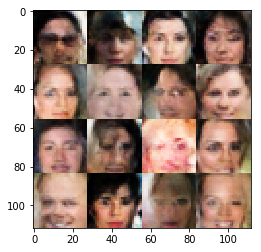

Epochs 0/1 Discrim Loss: 0.7460 Gen Loss: 2.5057
Epochs 0/1 Discrim Loss: 0.7555 Gen Loss: 0.9977
Epochs 0/1 Discrim Loss: 1.5107 Gen Loss: 0.3614
Epochs 0/1 Discrim Loss: 1.0120 Gen Loss: 0.6650
Epochs 0/1 Discrim Loss: 0.8687 Gen Loss: 0.8891


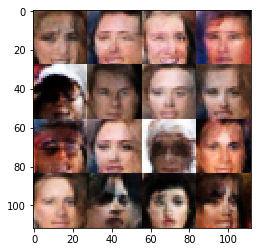

Epochs 0/1 Discrim Loss: 0.4866 Gen Loss: 1.2667
Epochs 0/1 Discrim Loss: 2.1783 Gen Loss: 0.1585
Epochs 0/1 Discrim Loss: 0.6576 Gen Loss: 1.1652
Epochs 0/1 Discrim Loss: 0.4383 Gen Loss: 1.9592
Epochs 0/1 Discrim Loss: 1.0089 Gen Loss: 4.0421


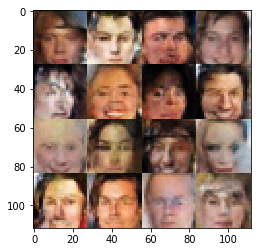

Epochs 0/1 Discrim Loss: 0.6635 Gen Loss: 0.9402
Epochs 0/1 Discrim Loss: 0.5218 Gen Loss: 1.4501
Epochs 0/1 Discrim Loss: 0.6880 Gen Loss: 0.9674
Epochs 0/1 Discrim Loss: 0.5510 Gen Loss: 1.5923
Epochs 0/1 Discrim Loss: 0.9468 Gen Loss: 0.6643


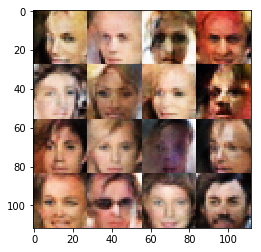

Epochs 0/1 Discrim Loss: 0.7642 Gen Loss: 0.8302
Epochs 0/1 Discrim Loss: 0.6334 Gen Loss: 1.2039
Epochs 0/1 Discrim Loss: 0.6857 Gen Loss: 0.9019
Epochs 0/1 Discrim Loss: 1.5043 Gen Loss: 0.3593
Epochs 0/1 Discrim Loss: 0.9639 Gen Loss: 0.7632


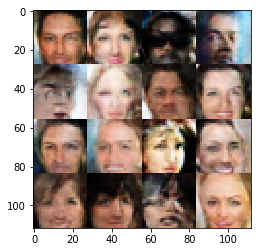

Epochs 0/1 Discrim Loss: 1.2104 Gen Loss: 0.4729
Epochs 0/1 Discrim Loss: 0.8505 Gen Loss: 0.7990
Epochs 0/1 Discrim Loss: 0.6432 Gen Loss: 1.0695
Epochs 0/1 Discrim Loss: 0.5567 Gen Loss: 2.4307
Epochs 0/1 Discrim Loss: 0.3845 Gen Loss: 2.3532


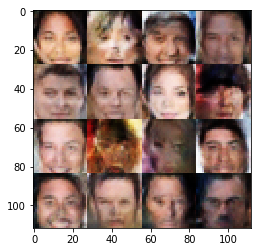

Epochs 0/1 Discrim Loss: 0.6435 Gen Loss: 0.9816
Epochs 0/1 Discrim Loss: 1.1908 Gen Loss: 0.5369
Epochs 0/1 Discrim Loss: 0.7983 Gen Loss: 0.8001
Epochs 0/1 Discrim Loss: 0.4530 Gen Loss: 1.6369
Epochs 0/1 Discrim Loss: 0.5693 Gen Loss: 1.7251


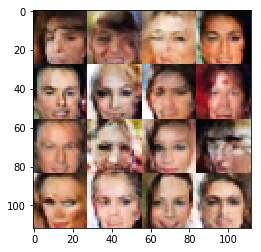

Epochs 0/1 Discrim Loss: 0.5477 Gen Loss: 1.1289
Epochs 0/1 Discrim Loss: 1.3569 Gen Loss: 0.4710
Epochs 0/1 Discrim Loss: 0.6176 Gen Loss: 1.1292
Epochs 0/1 Discrim Loss: 0.7734 Gen Loss: 0.8407
Epochs 0/1 Discrim Loss: 0.4245 Gen Loss: 1.6959


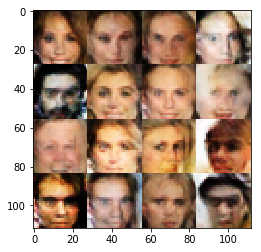

Epochs 0/1 Discrim Loss: 0.8578 Gen Loss: 0.8716
Epochs 0/1 Discrim Loss: 0.9525 Gen Loss: 0.7164
Epochs 0/1 Discrim Loss: 0.7499 Gen Loss: 0.9865
Epochs 0/1 Discrim Loss: 0.5152 Gen Loss: 1.9948
Epochs 0/1 Discrim Loss: 0.4757 Gen Loss: 1.9237


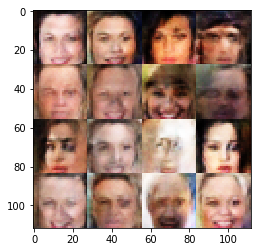

Epochs 0/1 Discrim Loss: 0.5471 Gen Loss: 1.3983
Epochs 0/1 Discrim Loss: 0.2819 Gen Loss: 1.9359
Epochs 0/1 Discrim Loss: 0.4140 Gen Loss: 1.9240
Epochs 0/1 Discrim Loss: 1.4594 Gen Loss: 0.3615
Epochs 0/1 Discrim Loss: 1.6152 Gen Loss: 0.3182


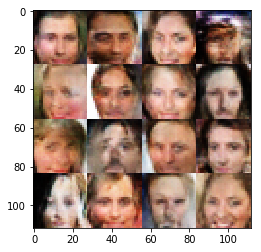

Epochs 0/1 Discrim Loss: 1.1131 Gen Loss: 3.0965
Epochs 0/1 Discrim Loss: 0.6883 Gen Loss: 1.0752
Epochs 0/1 Discrim Loss: 1.0851 Gen Loss: 0.5574
Epochs 0/1 Discrim Loss: 0.8656 Gen Loss: 0.7703
Epochs 0/1 Discrim Loss: 0.4854 Gen Loss: 1.8080


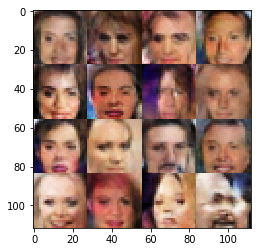

Epochs 0/1 Discrim Loss: 0.7089 Gen Loss: 1.0515
Epochs 0/1 Discrim Loss: 0.6232 Gen Loss: 1.3050
Epochs 0/1 Discrim Loss: 0.9144 Gen Loss: 0.6959
Epochs 0/1 Discrim Loss: 0.6430 Gen Loss: 0.9650
Epochs 0/1 Discrim Loss: 0.7373 Gen Loss: 0.8886


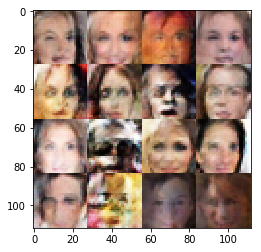

Epochs 0/1 Discrim Loss: 0.8659 Gen Loss: 0.8057
Epochs 0/1 Discrim Loss: 0.5885 Gen Loss: 2.2266
Epochs 0/1 Discrim Loss: 0.5900 Gen Loss: 2.7529
Epochs 0/1 Discrim Loss: 1.3148 Gen Loss: 0.4183
Epochs 0/1 Discrim Loss: 0.4495 Gen Loss: 2.7319


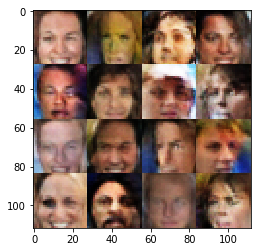

Epochs 0/1 Discrim Loss: 0.6217 Gen Loss: 1.0383
Epochs 0/1 Discrim Loss: 1.0683 Gen Loss: 0.5908
Epochs 0/1 Discrim Loss: 0.5353 Gen Loss: 1.2610
Epochs 0/1 Discrim Loss: 0.3946 Gen Loss: 1.7636
Epochs 0/1 Discrim Loss: 0.5488 Gen Loss: 1.4067


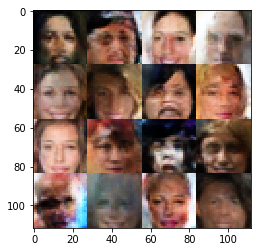

Epochs 0/1 Discrim Loss: 0.1859 Gen Loss: 2.6110
Epochs 0/1 Discrim Loss: 0.7124 Gen Loss: 1.0748
Epochs 0/1 Discrim Loss: 0.5697 Gen Loss: 1.1703
Epochs 0/1 Discrim Loss: 0.4468 Gen Loss: 1.8771
Epochs 0/1 Discrim Loss: 0.5728 Gen Loss: 1.2320


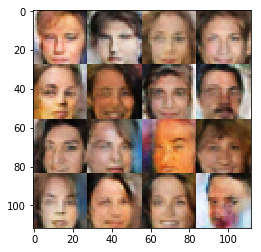

Epochs 0/1 Discrim Loss: 0.8246 Gen Loss: 3.4881
Epochs 0/1 Discrim Loss: 1.7082 Gen Loss: 0.3035
Epochs 0/1 Discrim Loss: 1.6484 Gen Loss: 0.2924
Epochs 0/1 Discrim Loss: 0.5644 Gen Loss: 1.3873
Epochs 0/1 Discrim Loss: 1.1326 Gen Loss: 0.5704


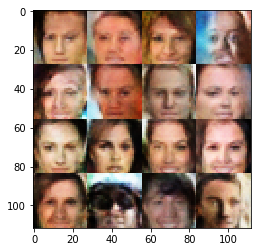

Epochs 0/1 Discrim Loss: 1.3683 Gen Loss: 0.4131
Epochs 0/1 Discrim Loss: 0.4070 Gen Loss: 2.0683
Epochs 0/1 Discrim Loss: 0.4545 Gen Loss: 1.7499
Epochs 0/1 Discrim Loss: 0.7757 Gen Loss: 0.8810
Epochs 0/1 Discrim Loss: 0.5036 Gen Loss: 1.1267


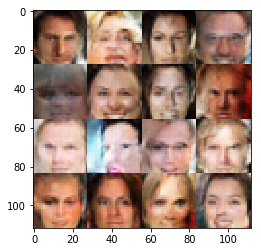

Epochs 0/1 Discrim Loss: 0.6157 Gen Loss: 1.0445
Epochs 0/1 Discrim Loss: 1.1199 Gen Loss: 4.0549
Epochs 0/1 Discrim Loss: 0.7641 Gen Loss: 1.0364
Epochs 0/1 Discrim Loss: 0.9517 Gen Loss: 0.6887
Epochs 0/1 Discrim Loss: 0.7353 Gen Loss: 0.8799


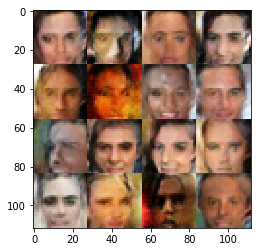

Epochs 0/1 Discrim Loss: 0.6868 Gen Loss: 1.2021
Epochs 0/1 Discrim Loss: 1.7107 Gen Loss: 0.2727
Epochs 0/1 Discrim Loss: 1.3479 Gen Loss: 0.4280
Epochs 0/1 Discrim Loss: 0.3769 Gen Loss: 1.6948
Epochs 0/1 Discrim Loss: 0.5687 Gen Loss: 2.3165


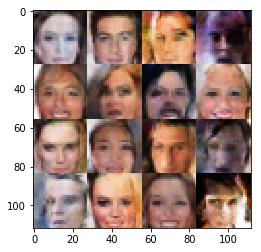

Epochs 0/1 Discrim Loss: 0.9652 Gen Loss: 0.8091
Epochs 0/1 Discrim Loss: 0.6006 Gen Loss: 1.1091
Epochs 0/1 Discrim Loss: 0.4728 Gen Loss: 1.8357
Epochs 0/1 Discrim Loss: 1.1210 Gen Loss: 0.5028
Epochs 0/1 Discrim Loss: 1.4877 Gen Loss: 0.3594


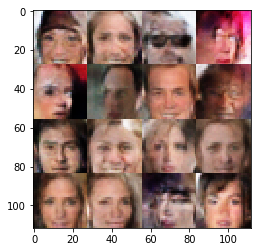

Epochs 0/1 Discrim Loss: 0.7575 Gen Loss: 0.8284
Epochs 0/1 Discrim Loss: 1.8180 Gen Loss: 0.2573
Epochs 0/1 Discrim Loss: 0.3494 Gen Loss: 1.8819
Epochs 0/1 Discrim Loss: 1.4767 Gen Loss: 0.3333
Epochs 0/1 Discrim Loss: 0.5016 Gen Loss: 1.4352


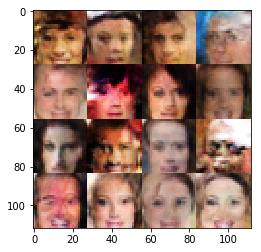

Epochs 0/1 Discrim Loss: 0.6462 Gen Loss: 0.9576
Epochs 0/1 Discrim Loss: 0.7978 Gen Loss: 0.8803
Epochs 0/1 Discrim Loss: 0.7651 Gen Loss: 1.0828
Epochs 0/1 Discrim Loss: 1.0727 Gen Loss: 0.6999
Epochs 0/1 Discrim Loss: 0.3550 Gen Loss: 1.6670


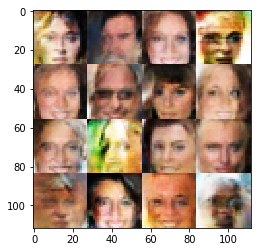

Epochs 0/1 Discrim Loss: 1.3254 Gen Loss: 0.4048
Epochs 0/1 Discrim Loss: 0.3547 Gen Loss: 2.0452
Epochs 0/1 Discrim Loss: 0.3703 Gen Loss: 1.7273
Epochs 0/1 Discrim Loss: 0.8961 Gen Loss: 2.5345
Epochs 0/1 Discrim Loss: 1.9684 Gen Loss: 0.2303


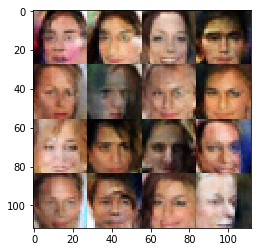

Epochs 0/1 Discrim Loss: 1.5278 Gen Loss: 2.7632
Epochs 0/1 Discrim Loss: 0.4472 Gen Loss: 1.4330
Epochs 0/1 Discrim Loss: 1.0168 Gen Loss: 0.6641
Epochs 0/1 Discrim Loss: 0.6327 Gen Loss: 1.2387
Epochs 0/1 Discrim Loss: 0.6994 Gen Loss: 0.9522


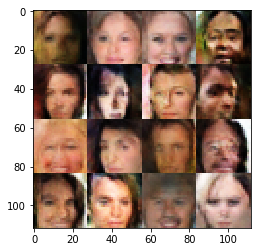

Epochs 0/1 Discrim Loss: 1.4426 Gen Loss: 0.4134
Epochs 0/1 Discrim Loss: 1.0054 Gen Loss: 0.8663
Epochs 0/1 Discrim Loss: 0.4447 Gen Loss: 1.5839
Epochs 0/1 Discrim Loss: 0.3668 Gen Loss: 2.1144
Epochs 0/1 Discrim Loss: 0.5031 Gen Loss: 1.7748


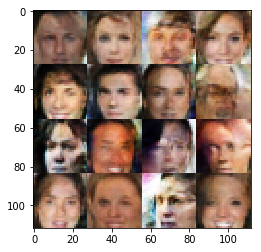

Epochs 0/1 Discrim Loss: 1.2787 Gen Loss: 0.5470
Epochs 0/1 Discrim Loss: 0.5934 Gen Loss: 1.8001
Epochs 0/1 Discrim Loss: 1.0606 Gen Loss: 0.6016
Epochs 0/1 Discrim Loss: 0.6224 Gen Loss: 1.1307
Epochs 0/1 Discrim Loss: 0.5441 Gen Loss: 1.2828


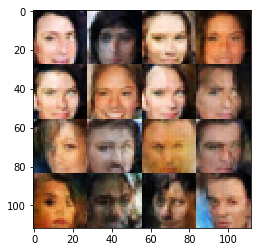

Epochs 0/1 Discrim Loss: 0.5508 Gen Loss: 1.3712
Epochs 0/1 Discrim Loss: 0.5339 Gen Loss: 1.4315
Epochs 0/1 Discrim Loss: 1.5330 Gen Loss: 0.3274
Epochs 0/1 Discrim Loss: 1.1210 Gen Loss: 0.5137
Epochs 0/1 Discrim Loss: 0.3093 Gen Loss: 2.1511


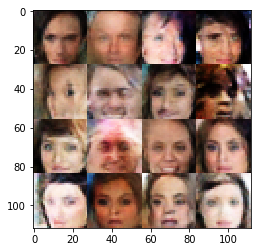

Epochs 0/1 Discrim Loss: 0.4422 Gen Loss: 1.5845
Epochs 0/1 Discrim Loss: 1.0083 Gen Loss: 0.5861
Epochs 0/1 Discrim Loss: 0.7686 Gen Loss: 0.9009
Epochs 0/1 Discrim Loss: 0.7004 Gen Loss: 1.0103
Epochs 0/1 Discrim Loss: 0.5399 Gen Loss: 1.4104


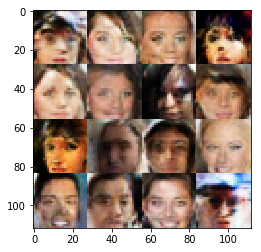

Epochs 0/1 Discrim Loss: 0.3463 Gen Loss: 2.0212
Epochs 0/1 Discrim Loss: 0.5154 Gen Loss: 2.0674
Epochs 0/1 Discrim Loss: 1.2410 Gen Loss: 0.5343
Epochs 0/1 Discrim Loss: 2.1155 Gen Loss: 0.1656
Epochs 0/1 Discrim Loss: 0.5397 Gen Loss: 2.4054


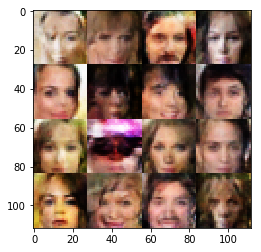

Epochs 0/1 Discrim Loss: 0.4983 Gen Loss: 1.4073
Epochs 0/1 Discrim Loss: 0.8756 Gen Loss: 0.7864
Epochs 0/1 Discrim Loss: 0.4661 Gen Loss: 1.3811
Epochs 0/1 Discrim Loss: 0.8255 Gen Loss: 0.7968
Epochs 0/1 Discrim Loss: 0.6260 Gen Loss: 0.9956


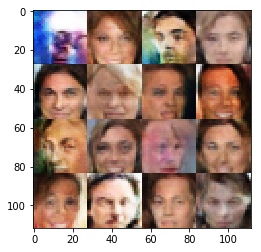

Epochs 0/1 Discrim Loss: 1.1209 Gen Loss: 0.6550
Epochs 0/1 Discrim Loss: 1.6526 Gen Loss: 0.3315
Epochs 0/1 Discrim Loss: 0.7829 Gen Loss: 0.8669
Epochs 0/1 Discrim Loss: 0.9451 Gen Loss: 0.6958
Epochs 0/1 Discrim Loss: 1.1366 Gen Loss: 0.6214


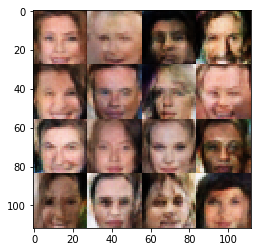

Epochs 0/1 Discrim Loss: 1.0530 Gen Loss: 0.5447
Epochs 0/1 Discrim Loss: 0.7102 Gen Loss: 0.9022
Epochs 0/1 Discrim Loss: 1.2113 Gen Loss: 0.4703
Epochs 0/1 Discrim Loss: 1.3602 Gen Loss: 0.3662
Epochs 0/1 Discrim Loss: 0.9708 Gen Loss: 0.6773


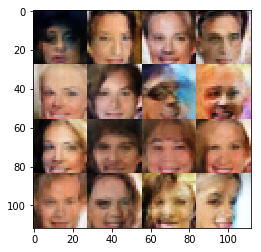

Epochs 0/1 Discrim Loss: 0.6610 Gen Loss: 1.0893
Epochs 0/1 Discrim Loss: 0.4824 Gen Loss: 1.4283
Epochs 0/1 Discrim Loss: 0.6017 Gen Loss: 1.3649
Epochs 0/1 Discrim Loss: 1.1818 Gen Loss: 0.4964
Epochs 0/1 Discrim Loss: 0.5590 Gen Loss: 1.1334


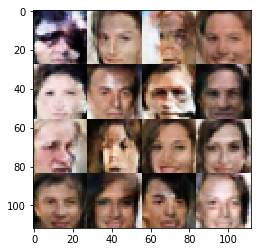

Epochs 0/1 Discrim Loss: 0.6235 Gen Loss: 2.7145
Epochs 0/1 Discrim Loss: 0.7779 Gen Loss: 0.8471
Epochs 0/1 Discrim Loss: 0.8877 Gen Loss: 0.7147
Epochs 0/1 Discrim Loss: 0.4856 Gen Loss: 1.3843
Epochs 0/1 Discrim Loss: 0.3664 Gen Loss: 2.5784


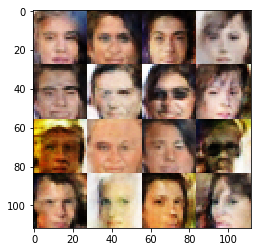

Epochs 0/1 Discrim Loss: 0.3715 Gen Loss: 2.7768
Epochs 0/1 Discrim Loss: 1.5499 Gen Loss: 0.2983
Epochs 0/1 Discrim Loss: 0.9189 Gen Loss: 3.4289
Epochs 0/1 Discrim Loss: 0.8149 Gen Loss: 0.7701


In [24]:
batch_size = 32
z_dim = 200
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
"""

Sources

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb
http://mohamedelgendy.com/portfolio/dlnd_face_generation.html
https://github.com/mdcramer/DCGAN-Face-Generation/blob/master/dlnd_face_generation2.py
http://www.sai-tai.com/demos/dl/face-generation.html
https://mauriciocodesso.com/post/face-generator/

"""

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.